
0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Definitions](#0.2-Definitions)<br>

    

1. **[Light yield functions](#1.-Light-yield-functions)**<br>
    1.1 [Ly total](#1.1-Total-light-yield) <br>
    1.2 [Ly top PMT array](#1.2-top-PMT-array-light-yield) <br>
    1.3 [Ly bottom PMT](#1.3-bottom-PMT-light-yield) <br>


2. **[Additional functions](#2.-Additional-functions)**<br>


3. **[Loop through waveforms](#3.-Loop-through-waveforms)**<br>
    3.1 [Compute light yields](#3.1-Compute-light-yields)<br>


4. **[Plots](#4.-Plots)**<br>
    4.1 [Average S1 41.5keV kr83m](#4.1-Average-S1-41.5keV-kr83m)<br>
    4.2 [Relative light yield](#4.2-Relative-light-yield)<br>
    4.3 [Absolute light yield along the TPC](#4.3-Absolute-light-yield-along-the-TPC)<br>


5. **[S1 correction](#5.-S1-correction)**<br>
    5.1 [Loop through waveforms and apply correction](#5.1-Loop-through-waveforms-and-apply-correction)<br>
    5.2 [Measured s1 along the TPC](#5.2-Measured-s1-along-the-TPC)<br>
    5.3 [Corrected s1 along the TPC](#5.3-Corrected-s1-along-the-TPC)<br>
    5.4 [Average corrected S1](#5.4-Average-corrected-S1)<br>
    5.5 [Playground](#5.5-Playground)<br>


6. **[3D visualisation](#6.-3D-visualisation)**<br>


7. **[Light yield for 9.4keV and 32.1keV](#7.-Light-yield-for-9.4keV-and-32.1keV)**<br>

# 0. Stuff

## 0.1 Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2 

Using TensorFlow backend.


## 0.2 Definitions

In [2]:
ctx = straxbra.XebraContext()
run = '00163'
peaks_data = ctx.get_array(run, 'peaks')
position_data = ctx.get_array(run, 'peak_positions')
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]
area_per_channel = peaks_data['area_per_channel']
x_position = position_data['x']
y_position = position_data['y']

# 1. Light yield functions

## 1.1 Ly total

In [3]:
def compute_ly():

    z_absolute = []
    for i in range(len(z)):
        z_absolute.append(abs(z[i]))
    bins_x = np.linspace(0,80,40)
    bins_y = np.linspace(100,600,40)

    def poisson_interval(k, alpha=0.318):
        a = alpha
        low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
        if k == 0:
            low = 0.0
        low_interval = k - low
        high_interval = high - k
        return low_interval, high_interval

    counts, xedges, yedges = np.histogram2d(z_absolute, s1, bins=(bins_x, bins_y))
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list_left = []
    poisson_list_right = []

    for i in counts:
        error_per_slice_left = []
        error_per_slice_right = []
        for j in i:
            b =poisson_interval(j)[1]
            a =poisson_interval(j)[0]
            error_per_slice_left.append(a)
            error_per_slice_right.append(b)
        poisson_list_left.append(error_per_slice_left)
        poisson_list_right.append(error_per_slice_right)
        
    fit_range= np.linspace(100,600,1000)

    p0 = [1,250,30]
    
    expectation_list = []
    error_list = []
    for i in range(2,32):   
        popt, pcov = curve_fit(gaus, ycenter, counts[i], p0, sigma = poisson_list_right[i], absolute_sigma = True, maxfev=100000)
        perr = np.sqrt(np.diag(pcov))



        expectation = popt[1]
        error = perr[1]
        expectation_list.append(expectation)
        error_list.append(error)

#     print(expectation_list)
#     print(error_list)

    return expectation_list, error_list


## 1.2 Ly top PMT array

In [4]:
def compute_ly_top():

    z_absolute = []
    for i in range(len(z)):
        z_absolute.append(abs(z[i]))
    bins_x = np.linspace(0,80,40)
    bins_y = np.linspace(0,80,40)

    def poisson_interval(k, alpha=0.318):
        a = alpha
        low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
        if k == 0:
            low = 0.0
        low_interval = k - low
        high_interval = high - k
        return low_interval, high_interval

    counts, xedges, yedges = np.histogram2d(z_absolute, s1_top, bins=(bins_x, bins_y))
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list_left = []
    poisson_list_right = []

    for i in counts:
        error_per_slice_left = []
        error_per_slice_right = []
        for j in i:
            b =poisson_interval(j)[1]
            a =poisson_interval(j)[0]
            error_per_slice_left.append(a)
            error_per_slice_right.append(b)
        poisson_list_left.append(error_per_slice_left)
        poisson_list_right.append(error_per_slice_right)
        
    fit_range= np.linspace(0,80,1000)

    p0 = [10,100,30]
    
    expectation_list_top = []
    error_list_top = []
    for i in range(2,32):   
        popt, pcov = curve_fit(gaus, ycenter, counts[i], p0, sigma = poisson_list_right[i], absolute_sigma = True, maxfev=100000)
        perr = np.sqrt(np.diag(pcov))



        expectation = popt[1]
        error = perr[1]
        expectation_list_top.append(expectation)
        error_list_top.append(error)

#     print(expectation_list)
#     print(error_list)

    return expectation_list_top, error_list_top


## 1.3 Ly bottom PMT

In [5]:
def compute_ly_bot():

    z_absolute = []
    for i in range(len(z)):
        z_absolute.append(abs(z[i]))
    bins_x = np.linspace(0,80,40)
    bins_y = np.linspace(100,600,40)

    def poisson_interval(k, alpha=0.318):
        a = alpha
        low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
        if k == 0:
            low = 0.0
        low_interval = k - low
        high_interval = high - k
        return low_interval, high_interval

    counts, xedges, yedges = np.histogram2d(z_absolute, s1_bot, bins=(bins_x, bins_y))
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list_left = []
    poisson_list_right = []

    for i in counts:
        error_per_slice_left = []
        error_per_slice_right = []
        for j in i:
            b =poisson_interval(j)[1]
            a =poisson_interval(j)[0]
            error_per_slice_left.append(a)
            error_per_slice_right.append(b)
        poisson_list_left.append(error_per_slice_left)
        poisson_list_right.append(error_per_slice_right)
        
    fit_range= np.linspace(100,600,1000)

    p0 = [10,250,30]
    
    expectation_list_bot = []
    error_list_bot = []
    for i in range(2,32):   
        popt, pcov = curve_fit(gaus, ycenter, counts[i], p0, sigma = poisson_list_right[i], absolute_sigma = True, maxfev=100000)
        perr = np.sqrt(np.diag(pcov))



        expectation = popt[1]
        error = perr[1]
        expectation_list_bot.append(expectation)
        error_list_bot.append(error)

#     print(expectation_list)
#     print(error_list)

    return expectation_list_bot, error_list_bot


# 2. Additional functions

In [6]:
def log_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus

def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus

def linear(x,m,c):
    linear = m*x+c  
    return linear

# def CutCondition(waveform):  
#     FirstPeak_area = sum(waveform[:15])
#     SecondPeak_area = sum(waveform[15:])    
#     if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
#         return(True)
#     else:
#         return(False)



def CutCondition(waveform):  
    FirstPeak_area = sum(waveform[:15])
    SecondPeak_area = sum(waveform[15:])
    FirstPeak_maximum = max(waveform[:15])
    SecondPeak_maximum = max(waveform[15:])
    SecondPeak_index = np.where(waveform == SecondPeak_maximum)
    SecondPeak_index_left = SecondPeak_index[0][0] -1
    SecondPeak_index_right = SecondPeak_index[0][0] +1
    SecondPeak_maximum_left = waveform[SecondPeak_index_left]
    SecondPeak_maximum_right = waveform[SecondPeak_index_right]

    
    
    
    if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200 \
    and SecondPeak_maximum < 0.5 * FirstPeak_maximum \
    and SecondPeak_maximum > 0.25 * FirstPeak_maximum \
    and SecondPeak_maximum > waveform[SecondPeak_index_left] \
    and SecondPeak_maximum > waveform[SecondPeak_index_right] \
    : 
        return(True)
    else:
        return(False)

def drifttime_to_z(t):
    return a * t + b

def S2_found(integral, width):
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

def decay_cut(timestamp, integral, width, i):
    
    time_diff = timestamp[i+1] - timestamp[i]
    if integral[i] > 100 \
    and integral[i] < 400 \
    and width[i] < 70 \
    and width[i] > 10 \
    and time_diff   < 1000 \
    and integral[i+1]   < 200 \
    and integral[i+1]   > 40 \
    and width[i+1] < 80\
    and width[i+1] > 20\
    :    
        return True
    else:
        return False    
    

def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval
    
def Process(waveform, i): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:
                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s2.append(integral[i+j])
                        s1.append(integral[i])
                        sum_area = sum(area_per_channel[i][1:8])
                        s1_top.append(sum_area)
                        s1_bot.append(area_per_channel[i][0])
                        x.append(x_position[i+j])
                        y.append(y_position[i+j])
                        z.append(z_position)
#                         time       = timestamp[i+j] - timestamp[i]
#                         drifttime.append(time)
#                         s2.append(integral[i+j])
#                         s1.append(integral[i])
#                         x.append(x_position[i+j])
#                         y.append(y_position[i+j])
#                         z.append(z_position)


#                         if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                             and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                             and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                             and area_per_channel[i+j][7] > 0 \
#                             :
#                             r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                             #r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             if r_position <= fiducial_r and z_position >= -70 and z_position <= -5:
#                                 time       = timestamp[i+j] - timestamp[i]
#                                 drifttime.append(time)
#                                 s2.append(integral[i+j])
#                                 s1.append(integral[i])
#                                 sum_area = sum(area_per_channel[i][1:8])
#                                 s1_top.append(sum_area)
#                                 s1_bot.append(area_per_channel[i][0])
#                                 r.append(r_position)
#                                 x.append(x_position[i+j])
#                                 y.append(y_position[i+j])
#                                 z.append(z_position)


                return
            else:
                return
            
            
def Process_corrected(waveform, i): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:
                        time_corrected       = timestamp[i+j] - timestamp[i]
                        drifttime_corrected.append(time_corrected)
                        s1_corrected.append(integral[i]/(shape*z_position+offset))
                        z_corrected.append(z_position)
                        ly.append(integral[i]/41.5)
                        ly_corrected.append((integral[i]/(shape*z_position+offset))/41.5)


#                         if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                             and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                             and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                             and area_per_channel[i+j][7] > 0 \
#                             :
#                             r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                             #r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             if r_position <= fiducial_r and z_position >= -70 and z_position <= -5:
#                                 time_corrected       = timestamp[i+j] - timestamp[i]
#                                 drifttime_corrected.append(time_corrected)
#                                 s1_corrected.append(integral[i]/(shape*z_position+offset))
#                                 z_corrected.append(z_position)
#                                 ly.append(integral[i]/41.5)
#                                 ly_corrected.append((integral[i]/(shape*z_position+offset))/41.5)








                return
            else:
                return
            

            
def Process_9keV_32keV(waveform, i):
    if decay_cut(timestamp,integral, width, i):
        
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:
                        s1_32keV.append(integral[i])
                        s1_9keV.append(integral[i+1])
                        s1_9keV_corrected.append(integral[i+1]/(shape_float*z_position+offset_float))
                        s1_32keV_corrected.append(integral[i]/(shape_float*z_position+offset_float))
                        
#                         if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                             and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                             and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                             and area_per_channel[i+j][7] > 0 \
#                             :
#                             r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
#                             #r_position = np.sqrt(x_position[i+j]**2 + y_position[i+j]**2)
#                             if r_position <= fiducial_r and z_position >= -70 and z_position <= -5:
#                                 s1_32keV.append(integral[i])
#                                 s1_9keV.append(integral[i+1])
#                                 s1_9keV_corrected.append(integral[i+1]/(shape_float*z_position+offset_float))
#                                 s1_32keV_corrected.append(integral[i]/(shape_float*z_position+offset_float))

        
        
        return
    else:
        return

# 3. Loop through waveforms

In [7]:

left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 23

s1 = []
s1_top = []
s1_bot = []
s2 = []
drifttime = []
r = []
x = []
y = []
z = []
                                                
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process(waveform,i)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')
    



0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00163 done!


## 3.1 Compute light yields

In [8]:
ly_z = compute_ly()
ly_z_bot = compute_ly_bot()
ly_z_top = compute_ly_top()

# 4. Plots

## 4.1 Average S1 41.5keV kr83m

In [1]:
fig, axes = ps.styles()

p0_log = [1,1,1]
p0 = [500,300,60]


n, binEdges = np.histogram(s1, bins=np.linspace(1,1000,100))  #anode at 2500V

poisson_list = []

for i in n:
    a= poisson_interval(i)[1]
    poisson_list.append(a)


bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
x_range = np.linspace(1,1000,1000)

popt, pcov = curve_fit(log_gaus, bincenters, n, p0_log,  sigma = poisson_list, absolute_sigma = True, maxfev = 10000)
perr = np.sqrt(np.diag(pcov))




expectation = np.exp(popt[1]+((popt[2]**2)/2))
diff_mu = expectation
diff_sigma = expectation*popt[2]
error_mu = perr[1]
error_sigma = perr[2]   
error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

s1_mu = f"{expectation:.1f}"


s1_ly = f"{(np.array(expectation)/41.5):.2f}"
s1_ly_error = f"{(np.array(error)/41.5):.2f}"
print('average ly of run',run[2:],': (',s1_ly,'+/-',s1_ly_error,')','keV/pe')
s1_error = f"{error:.1f}"




xdata=bincenters[1:-1]
ydata=n[1:-1]
chi_squared =  (np.sum((n - log_gaus(bincenters, *popt))**2 / np.array(poisson_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(xdata))
# print(Reduced_chi_squared)



axes.errorbar(bincenters, n, yerr=np.sqrt(n),marker = 'x', fmt='.',c = 'C7',markersize='10', ecolor='red', label='Average s1')
axes.plot(x_range,log_gaus(x_range,*popt), color = 'k', linestyle = '-.', label = 'mu = ('+s1_mu+ ' +/- '+s1_error+') pe')
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)
axes.set_title('Average s1 for the kr83m 41.5keV population - Run '+run[2:])
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average s1 area [pe]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()




NameError: name 'ps' is not defined

## 4.2 Relative light yield

This is the s1 correction function:  -0.0069 *z + 0.76


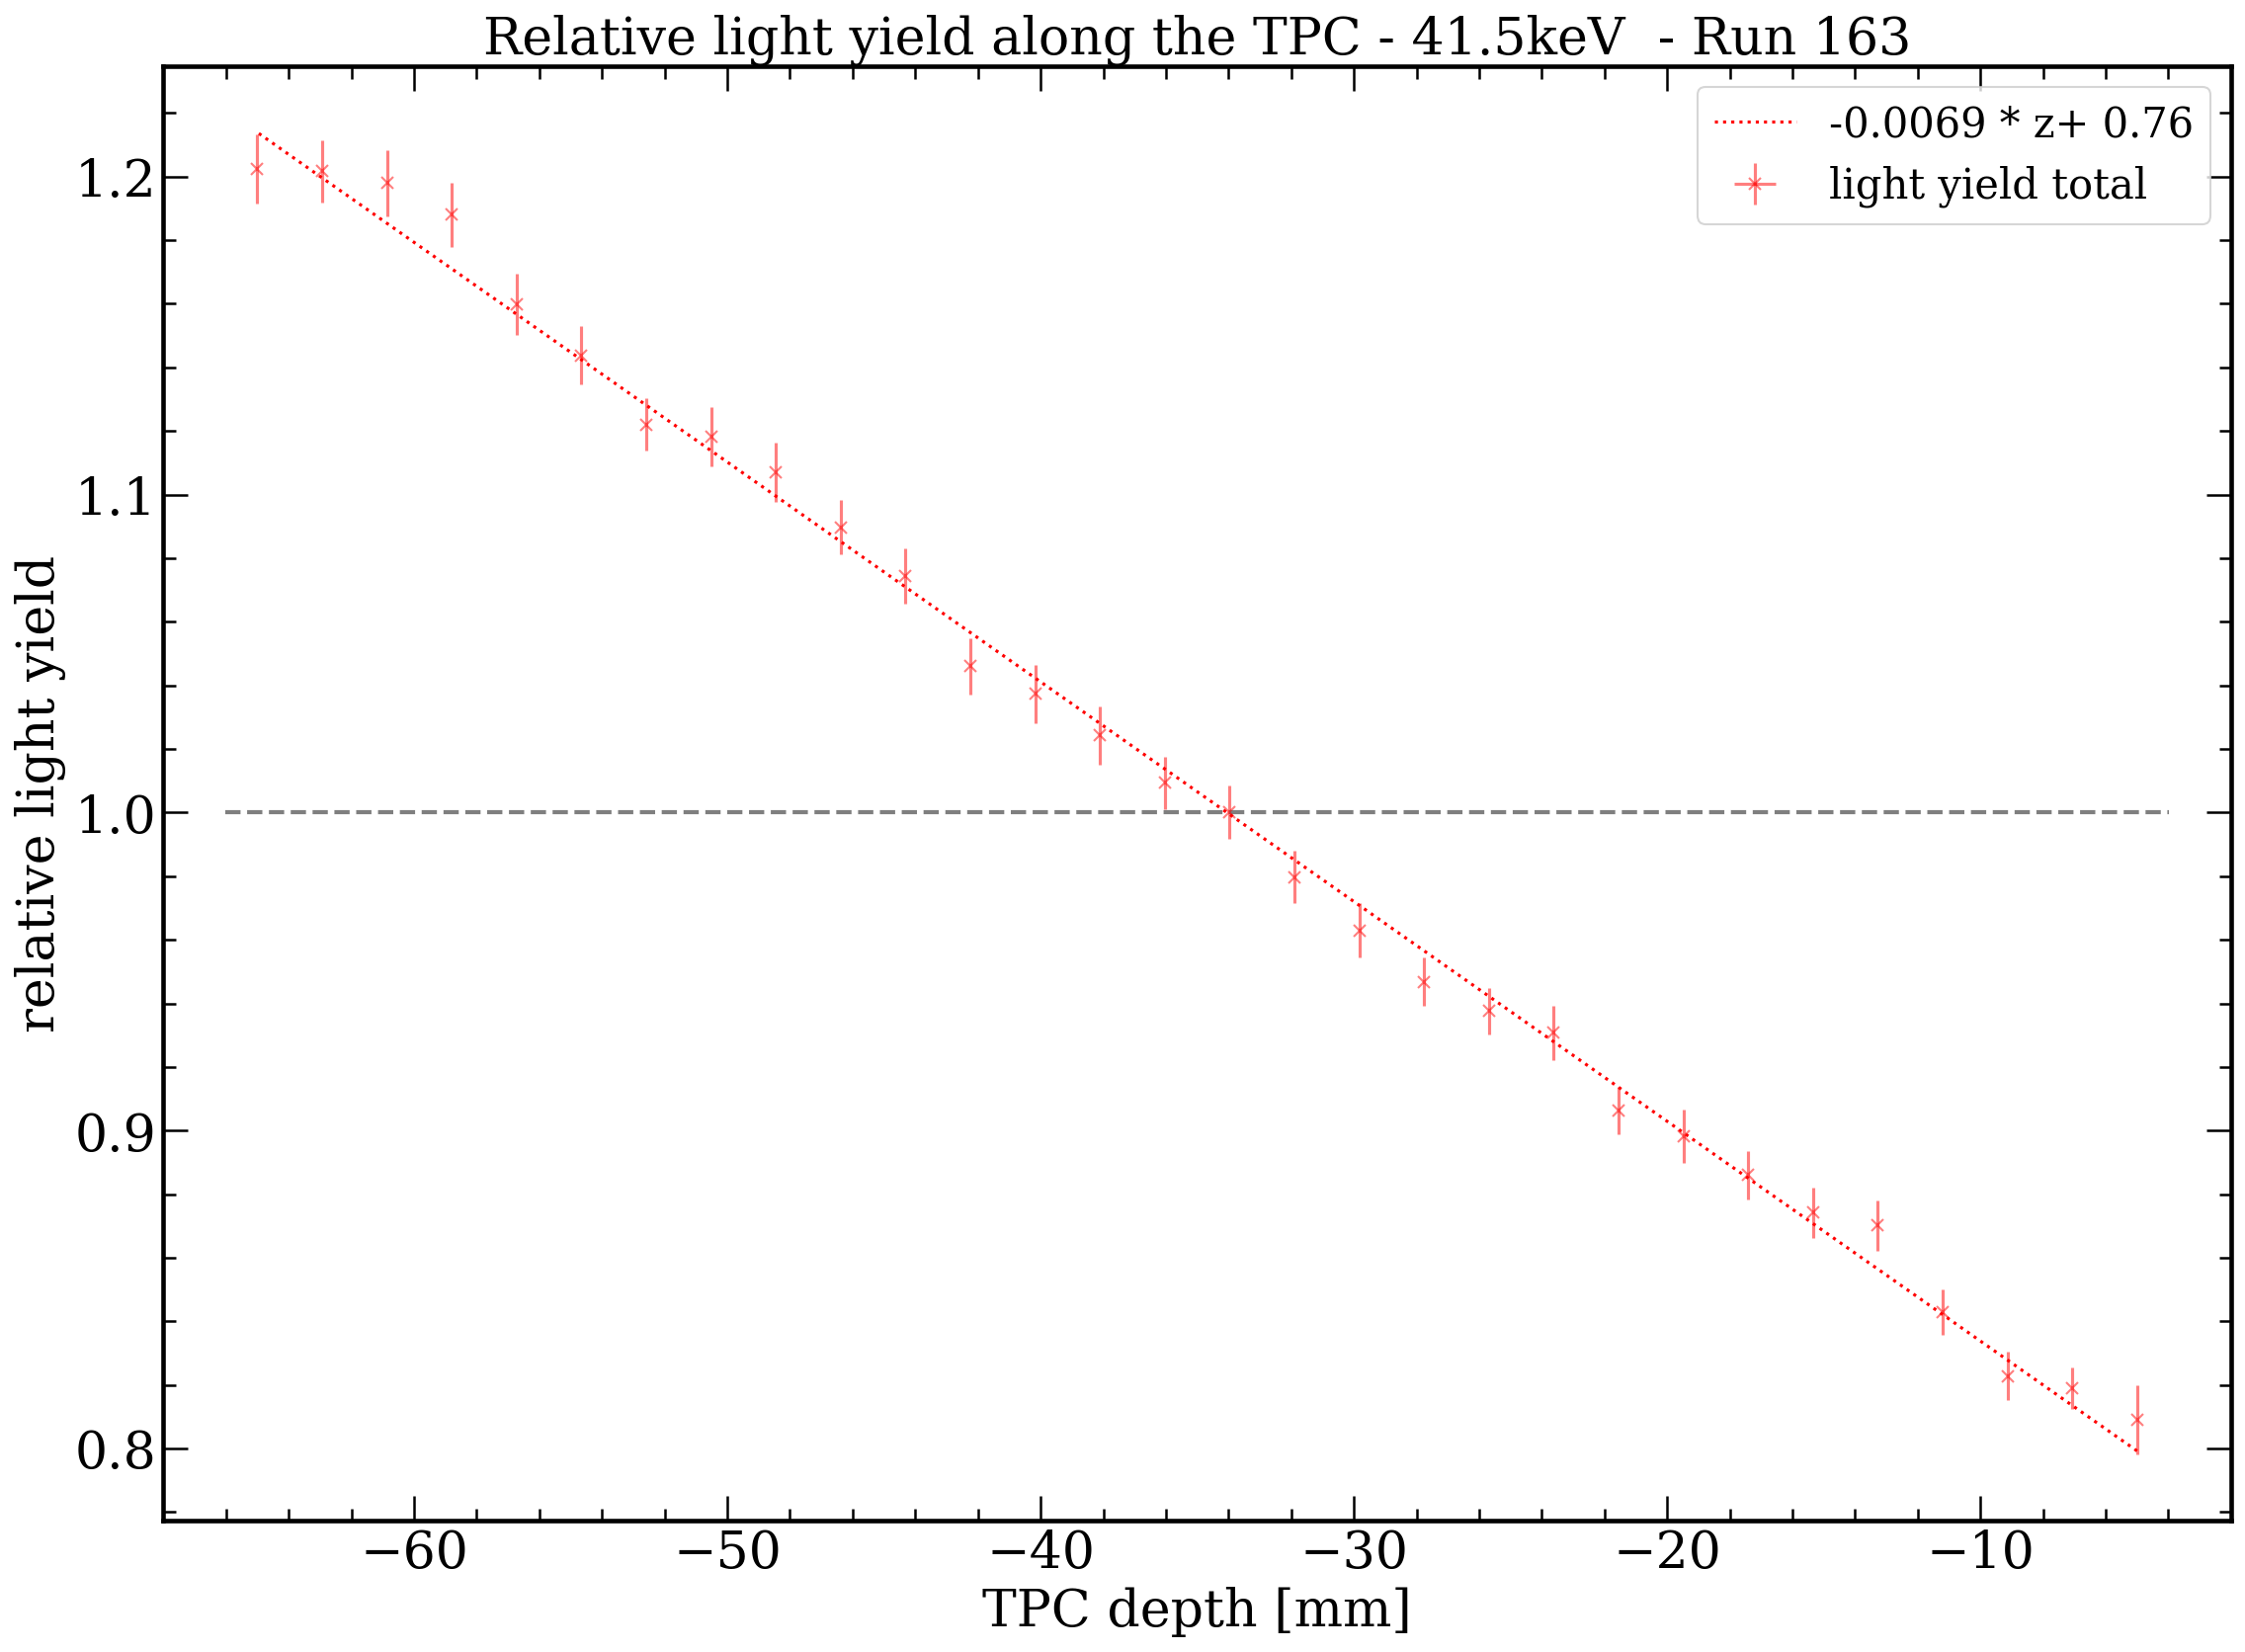

In [10]:
fig, axes = ps.styles()

p0=  [10,6]

s1_ly = float(s1_ly)
expectation_list, error_list = ly_z
expectation = (np.array(expectation_list))/(41.5)

error = float(s1_error)
relative_ly = np.array(expectation)/s1_ly
error = (np.array(error_list))/(41.5)
relative_error = (np.array(error))/s1_ly

x_range = np.linspace(-5,-65,30)

popt, pcov = curve_fit(linear, x_range, relative_ly, sigma=error, p0=p0, absolute_sigma=True, maxfev= 10000)
perr = np.sqrt(np.diag(pcov))
shape = f"{popt[0]:.4f}"
shape_error = perr[0]
offset_error = perr[1]
offset = f"{popt[1]:.2f}"
axes.axhline(y=1,xmin=0.03, xmax=0.97, linewidth=2,linestyle = '--',  color= "C7")
axes.errorbar(x_range, relative_ly, yerr=relative_error, xerr=0, fmt = 'rx', label = 'light yield total', alpha = 0.5 )
axes.plot(x_range,linear(x_range,*popt), color = 'r',linestyle = ':', label = shape+' * z+ '+offset)
axes.set_title('Relative light yield along the TPC - 41.5keV  - Run '+run[2:])
axes.set_xlabel('TPC depth [mm]')
axes.set_ylabel('relative light yield')
axes.legend(prop={'size': 20})
print('This is the s1 correction function: ', shape,'*z +',offset)
plt.show()

## 4.3 Absolute light yield along the TPC

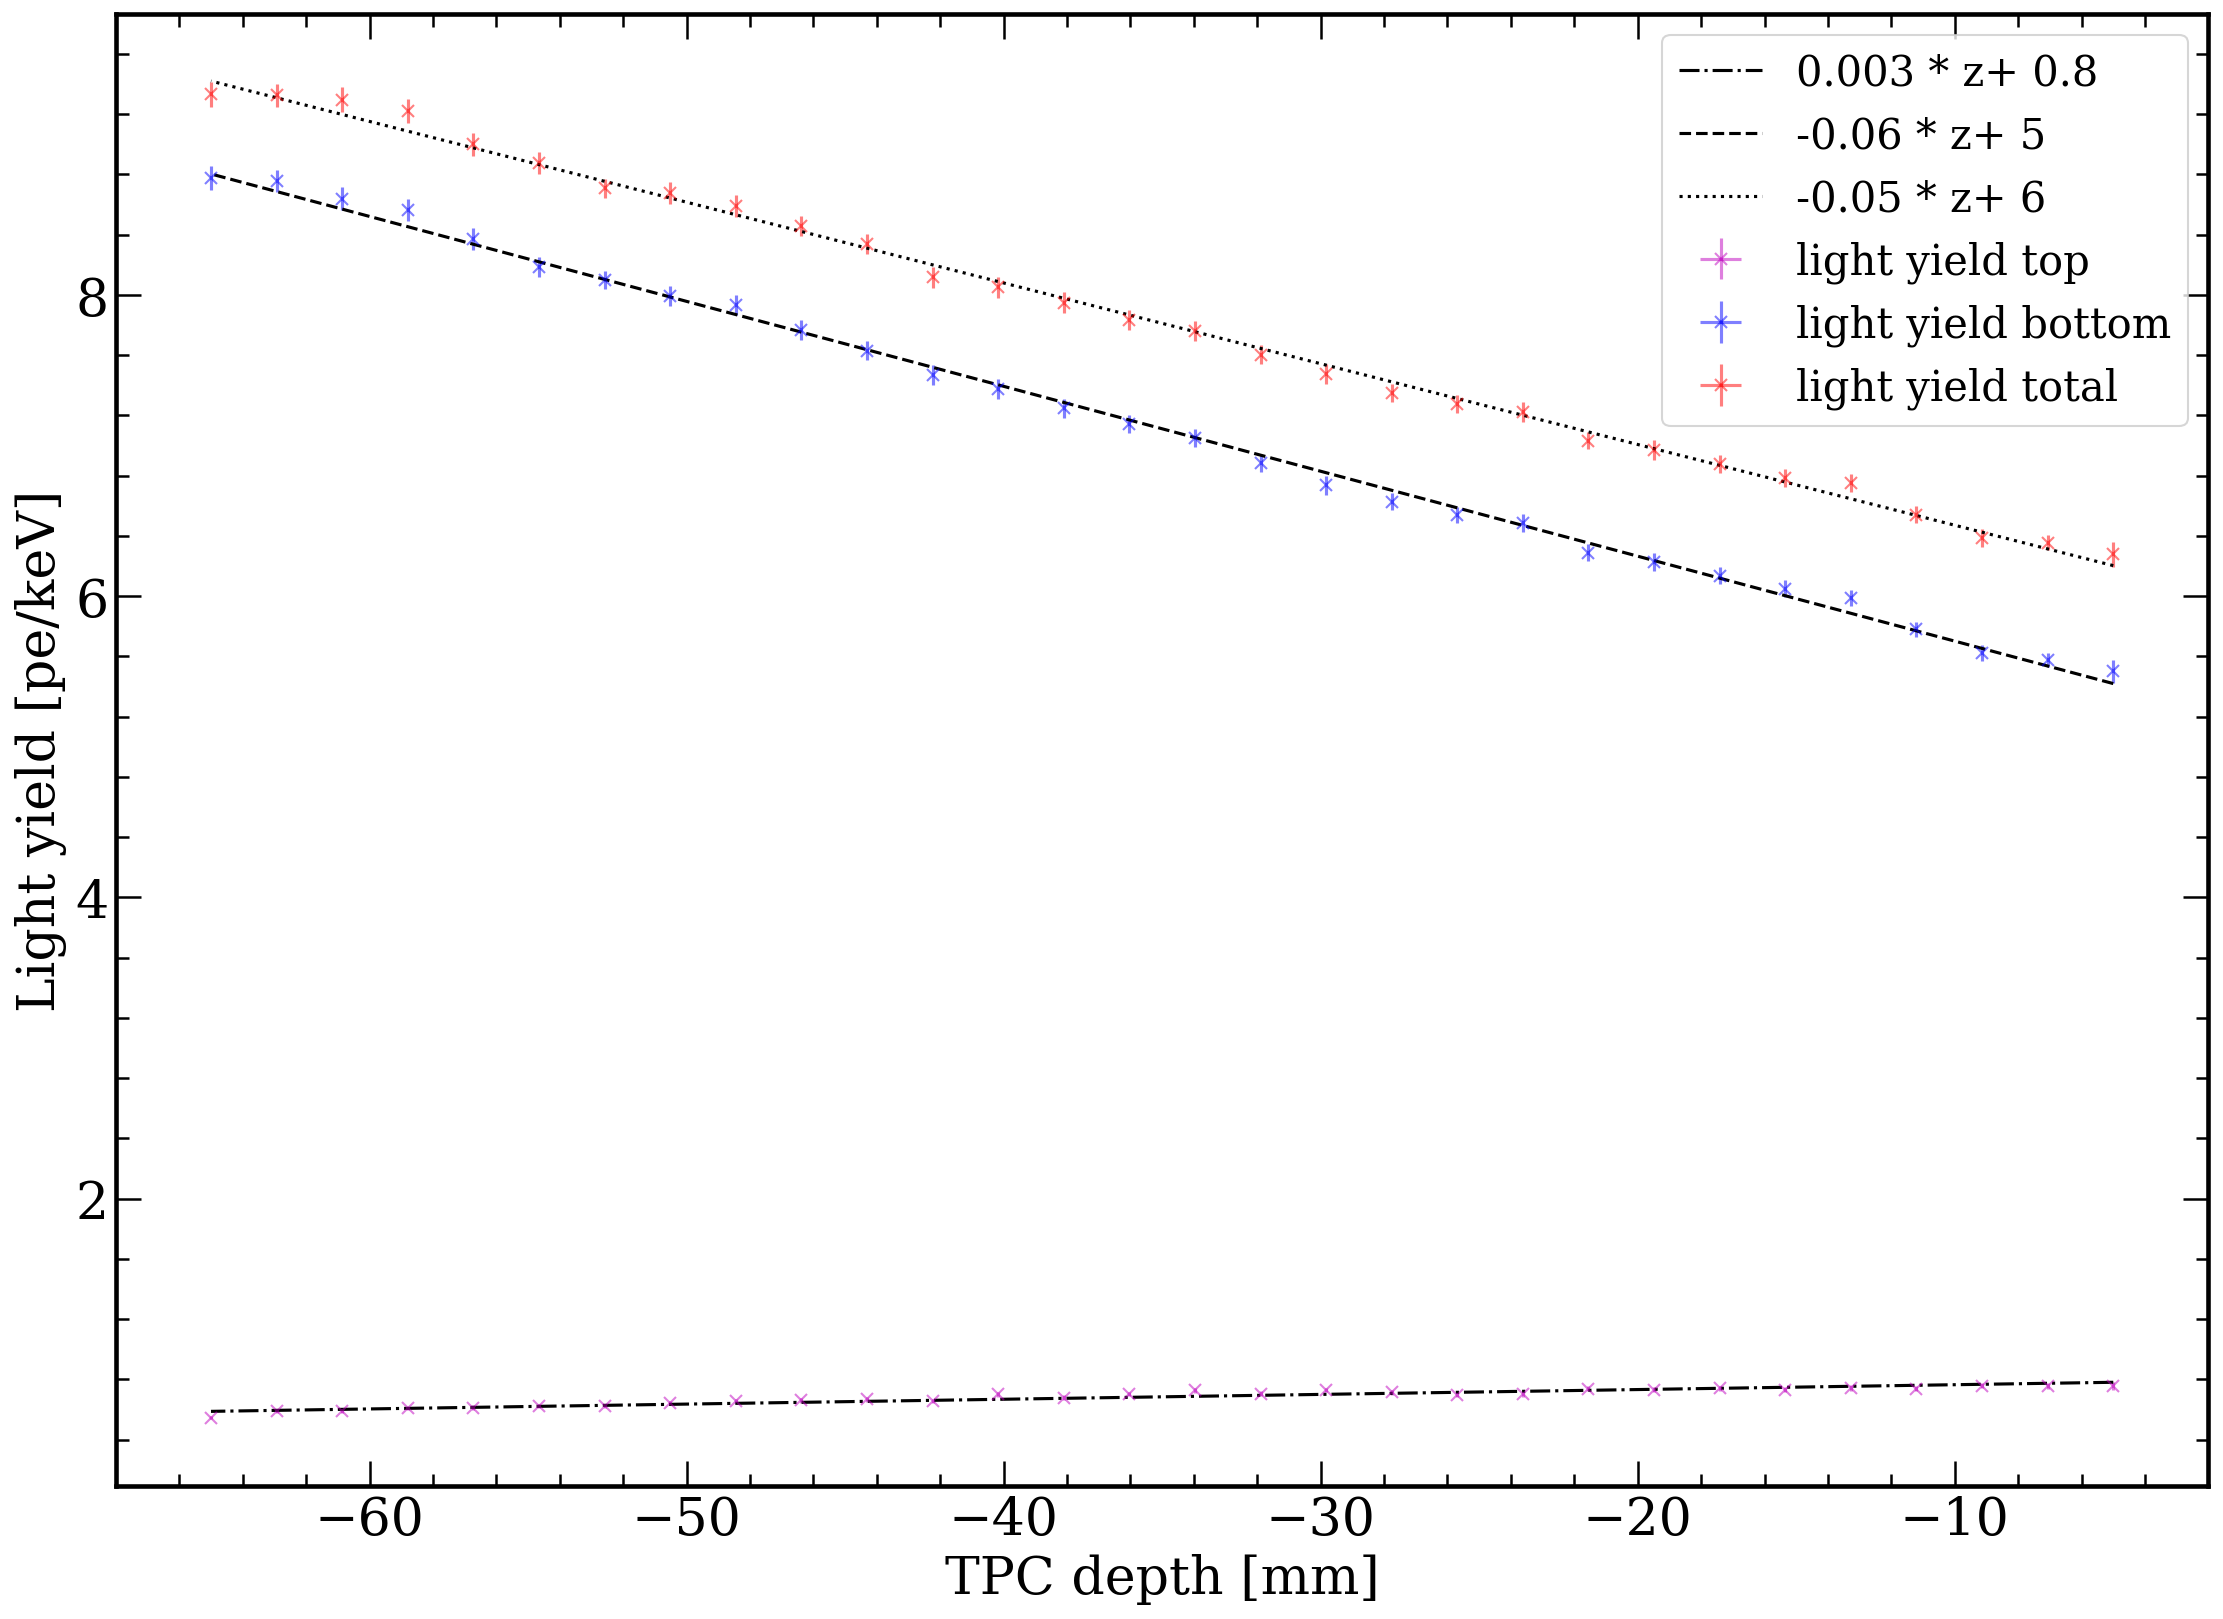

In [11]:
fig, axes = ps.styles()


p0=  [10,6]
p0_top = [1,1]
x_range = np.linspace(-5,-65,30)

expectation_list, error_list = ly_z
expectation_list_bot, error_list_bot = ly_z_bot
expectation_list_top, error_list_top = ly_z_top

expectation = (np.array(expectation_list))/(41.5)
expectation_bot = (np.array(expectation_list_bot))/(41.5)
expectation_top = (np.array(expectation_list_top))/(41.5)

error = (np.array(error_list))/(41.5)
error_bot = (np.array(error_list_bot))/(41.5)
error_top = (np.array(error_list_top))/(41.5)


popt, pcov = curve_fit(linear, x_range, expectation, sigma=error, p0=p0, absolute_sigma=True, maxfev= 10000)
popt_bot, pcov_bot = curve_fit(linear, x_range, expectation_bot, sigma=error_bot, p0=p0, absolute_sigma=True, maxfev= 10000)
popt_top, pcov_top = curve_fit(linear, x_range, expectation_top, sigma=error_top, p0=p0_top, absolute_sigma=True, maxfev= 10000)

# print(f"{popt[1]:.2f}")
# print(f"{popt[0]:.2f}")
c = f"{popt[1]:.0f}"
m = f"{popt[0]:.2f}"

a = f"{popt_bot[1]:.0f}"
b = f"{popt_bot[0]:.2f}"

d = f"{popt_top[1]:.1f}"
e = f"{popt_top[0]:.3f}"


perr_linear_fit = np.sqrt(np.diag(pcov))
# print('error on m', perr_linear_fit[0])

axes.errorbar(x_range, expectation_top, yerr=error_top, xerr=0, fmt = 'mx', label = 'light yield top', alpha = 0.5 )
axes.plot(x_range,linear(x_range,*popt_top), color = 'k',linestyle = '-.', label = e+' * z+ '+d)

axes.errorbar(x_range, expectation_bot, yerr=error_bot, xerr=0, fmt = 'bx', label = 'light yield bottom', alpha = 0.5 )
axes.plot(x_range,linear(x_range,*popt_bot), color = 'k',linestyle = '--', label = b+' * z+ '+a)

axes.errorbar(x_range, expectation, yerr=error, xerr=0, fmt = 'rx', label = 'light yield total', alpha = 0.5 )
axes.plot(x_range,linear(x_range,*popt), color = 'k',linestyle = ':', label = m+' * z+ '+c)
axes.set_xlabel('TPC depth [mm]')
axes.set_ylabel('Light yield [pe/keV]')
axes.legend(prop={'size': 20})

plt.show()


# 5. S1 correction

## 5.1 Loop through waveforms and apply correction

In [12]:

left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 23


s1_corrected = []
z_corrected = []
drifttime_corrected = []
ly = []
ly_corrected = []

shape = float(shape)
offset = float(offset)                                                          
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process_corrected(waveform,i)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')
    



0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00163 done!


## 5.2 Measured s1 along the TPC

No handles with labels found to put in legend.


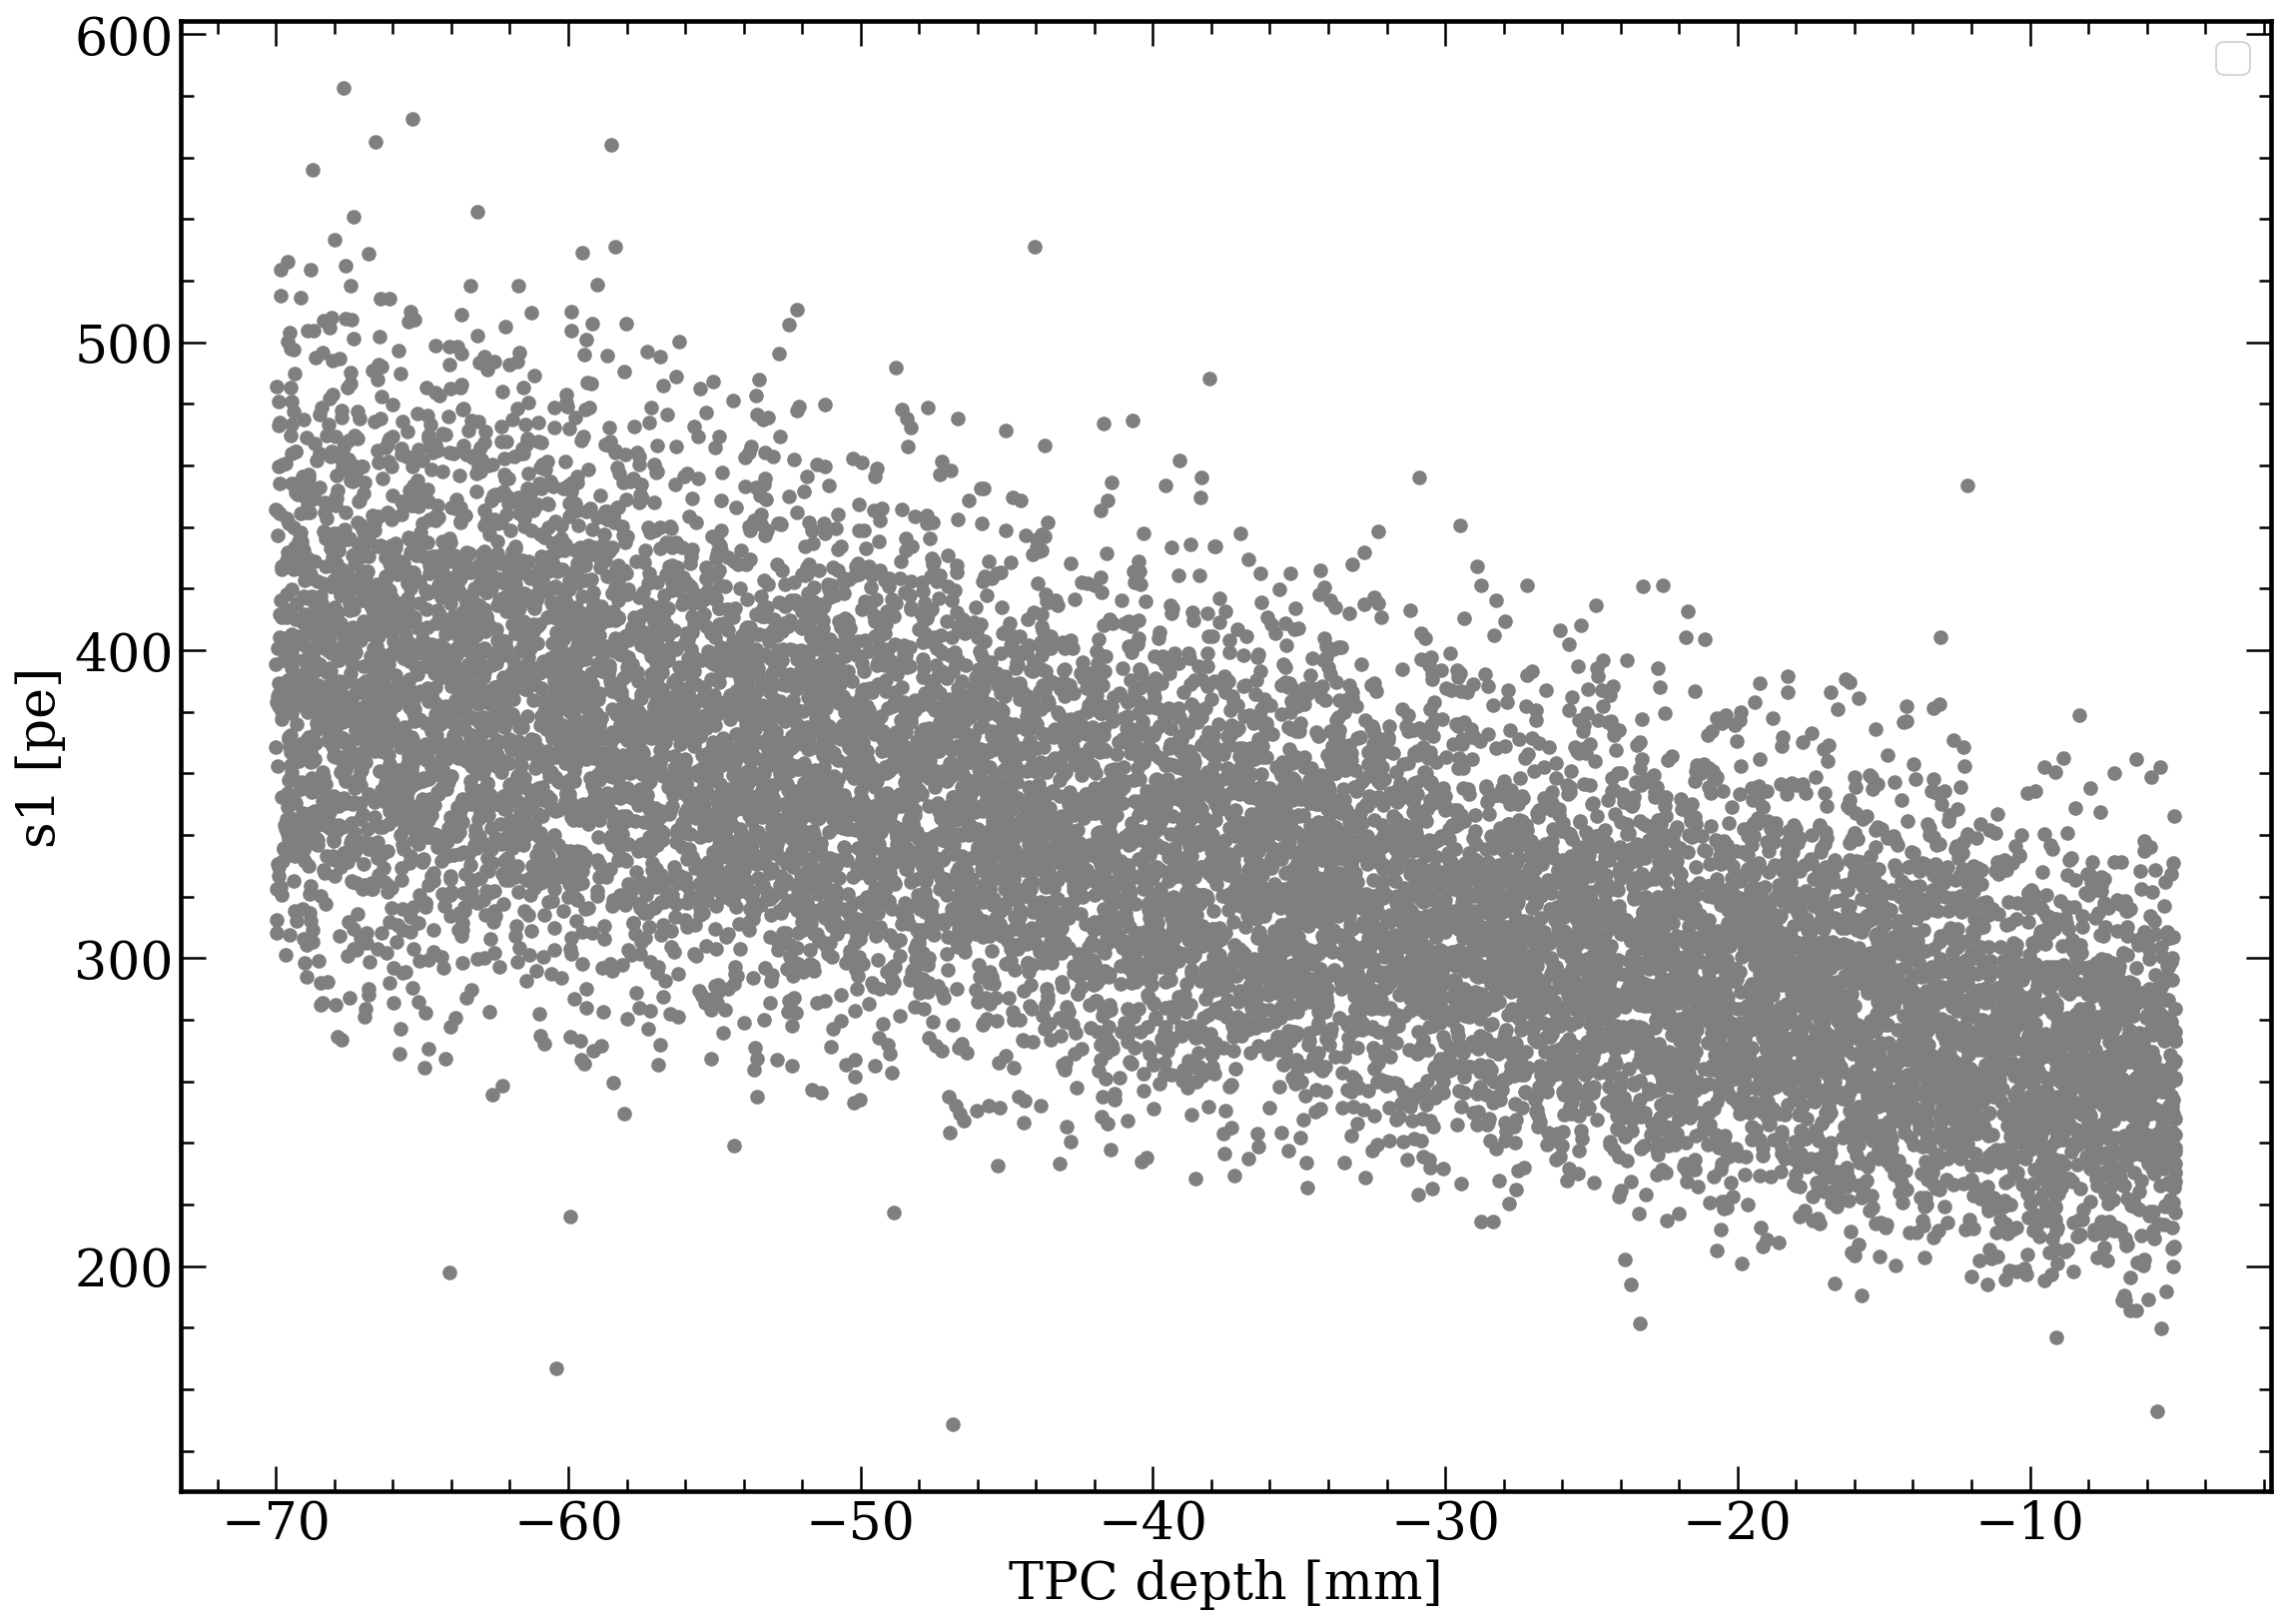

In [13]:
fig, axes = ps.styles()


axes.scatter(z,s1, c='C7')
axes.set_xlabel('TPC depth [mm]')
axes.set_ylabel('s1 [pe]')
axes.legend(prop={'size': 20})
plt.show()


## 5.3 Corrected s1 along the TPC

No handles with labels found to put in legend.


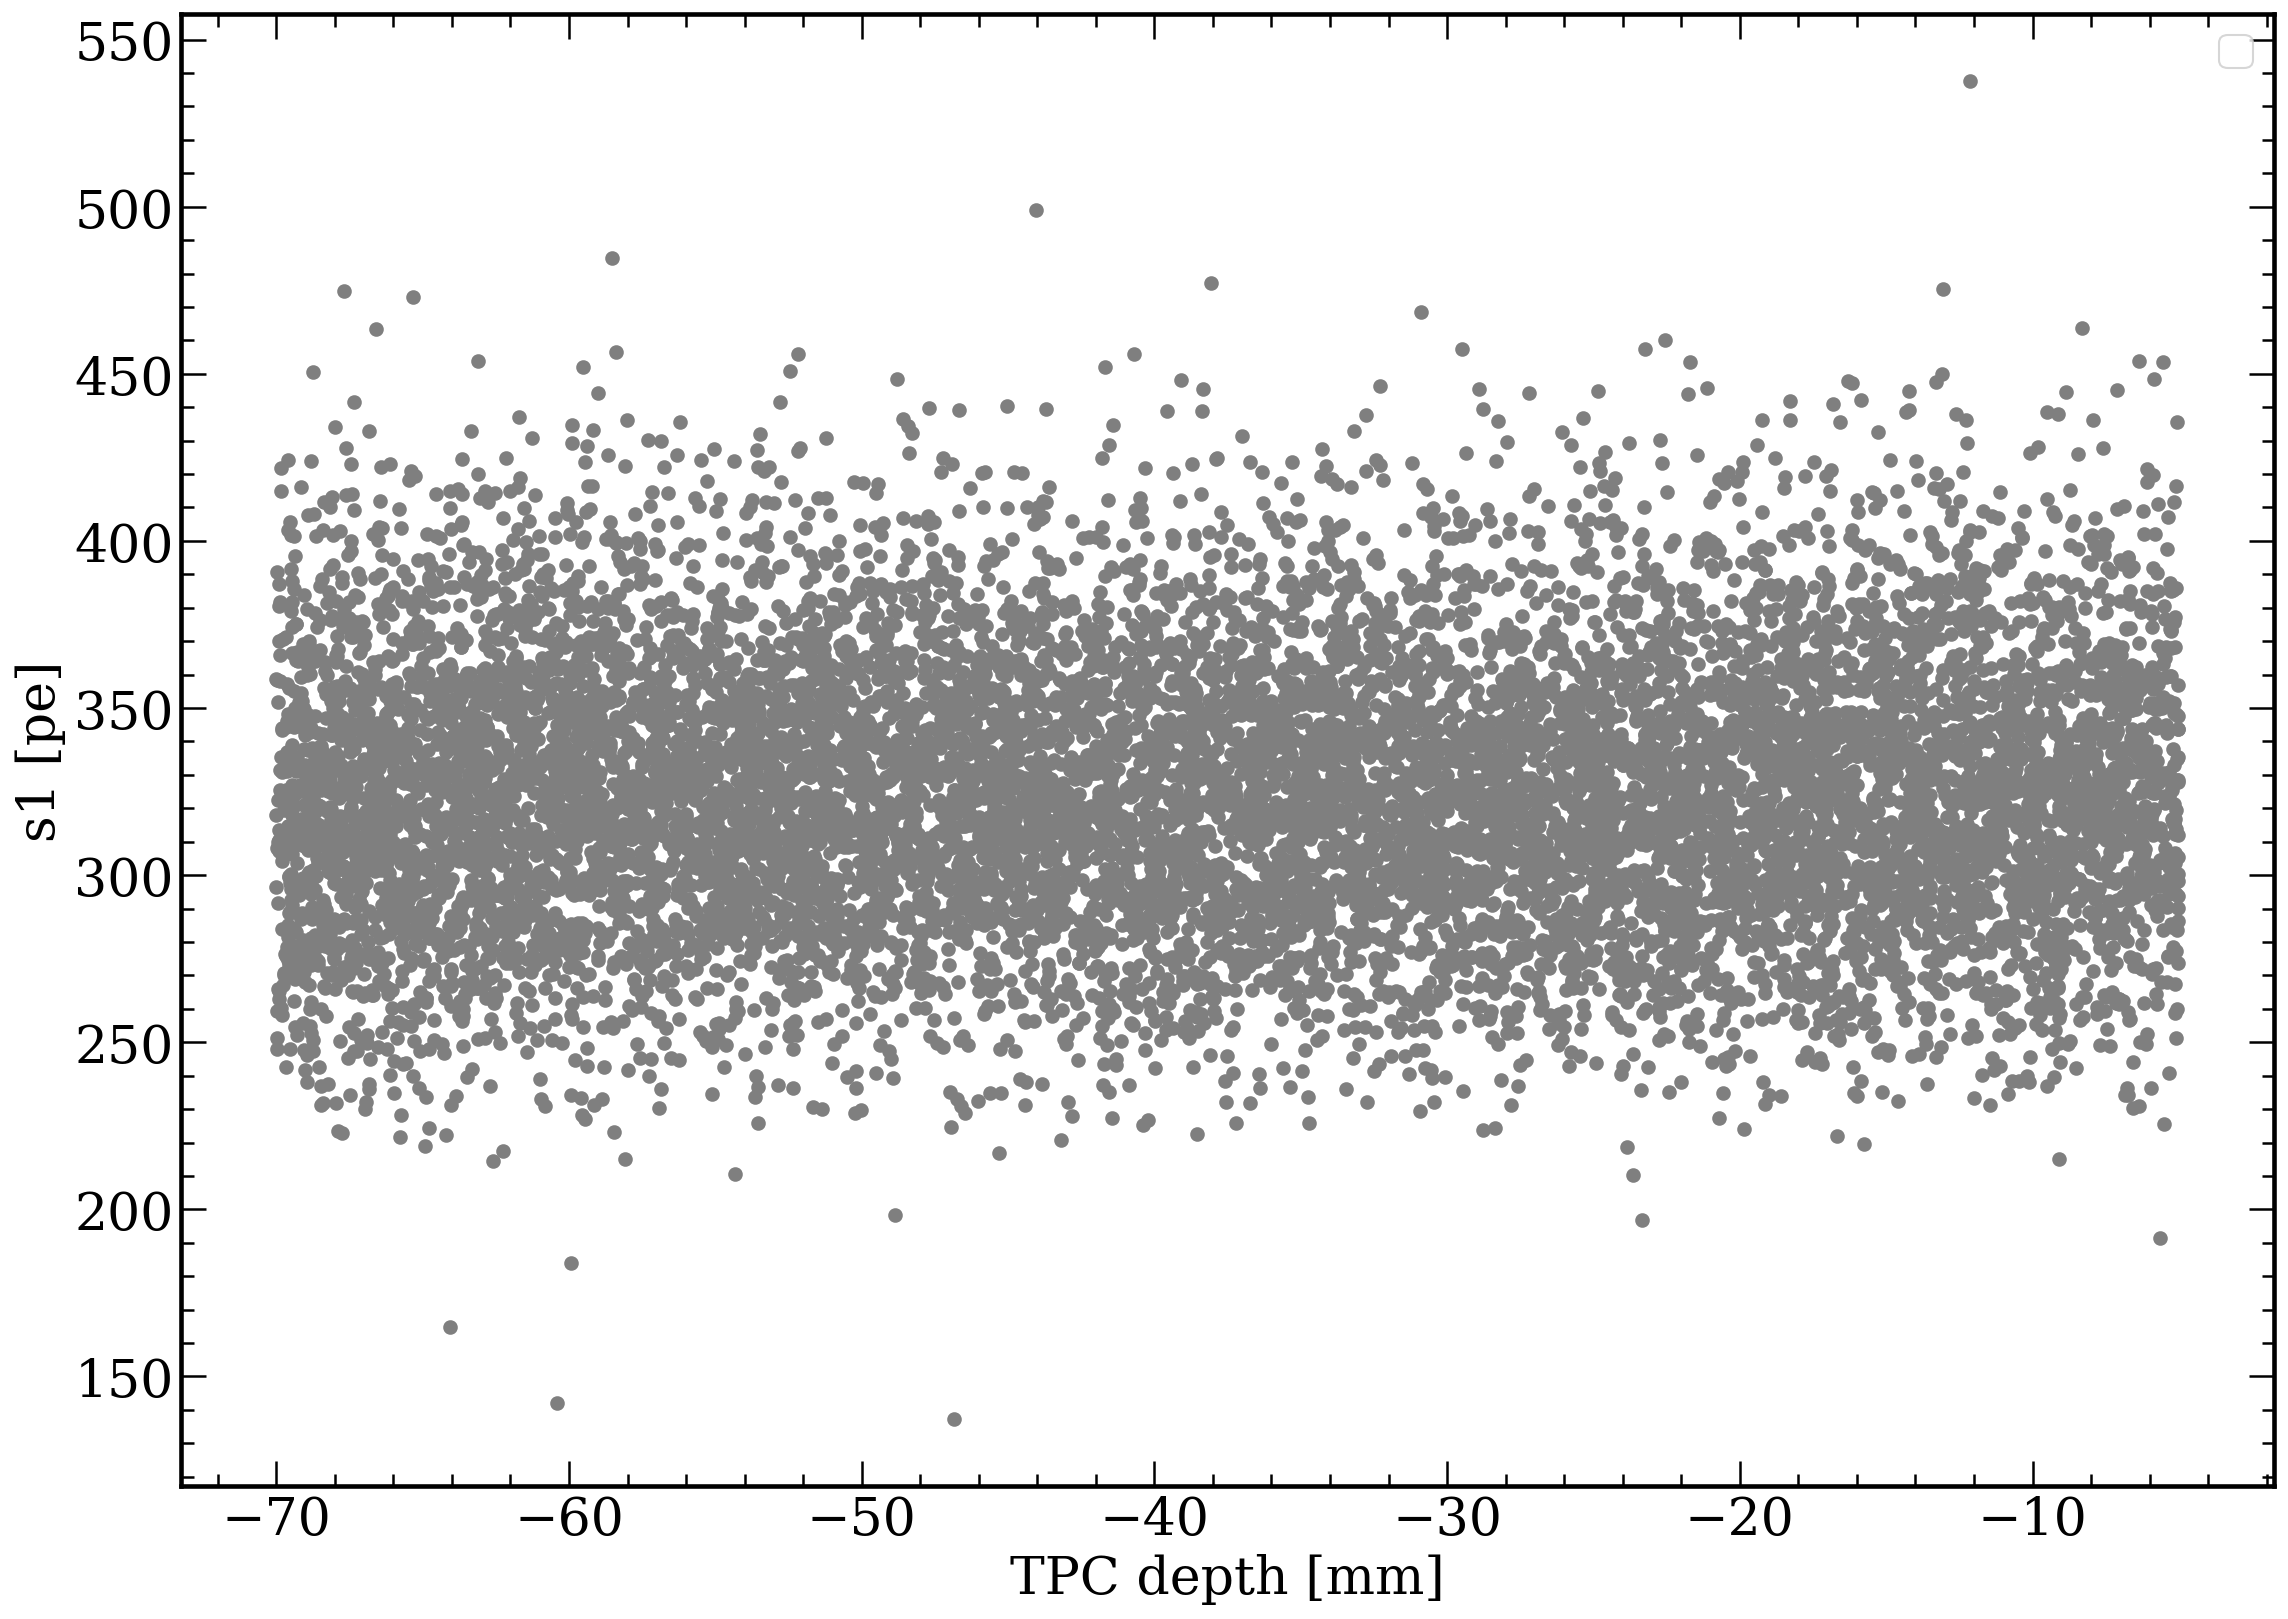

In [14]:
fig, axes = ps.styles()


axes.scatter(z_corrected,s1_corrected, c='C7')
axes.set_xlabel('TPC depth [mm]')
axes.set_ylabel('s1 [pe]')
axes.legend(prop={'size': 20})
plt.show()


## 5.4 Average corrected S1

average ly of run 163 : ( 7.82 +/- 0.01 ) keV/pe


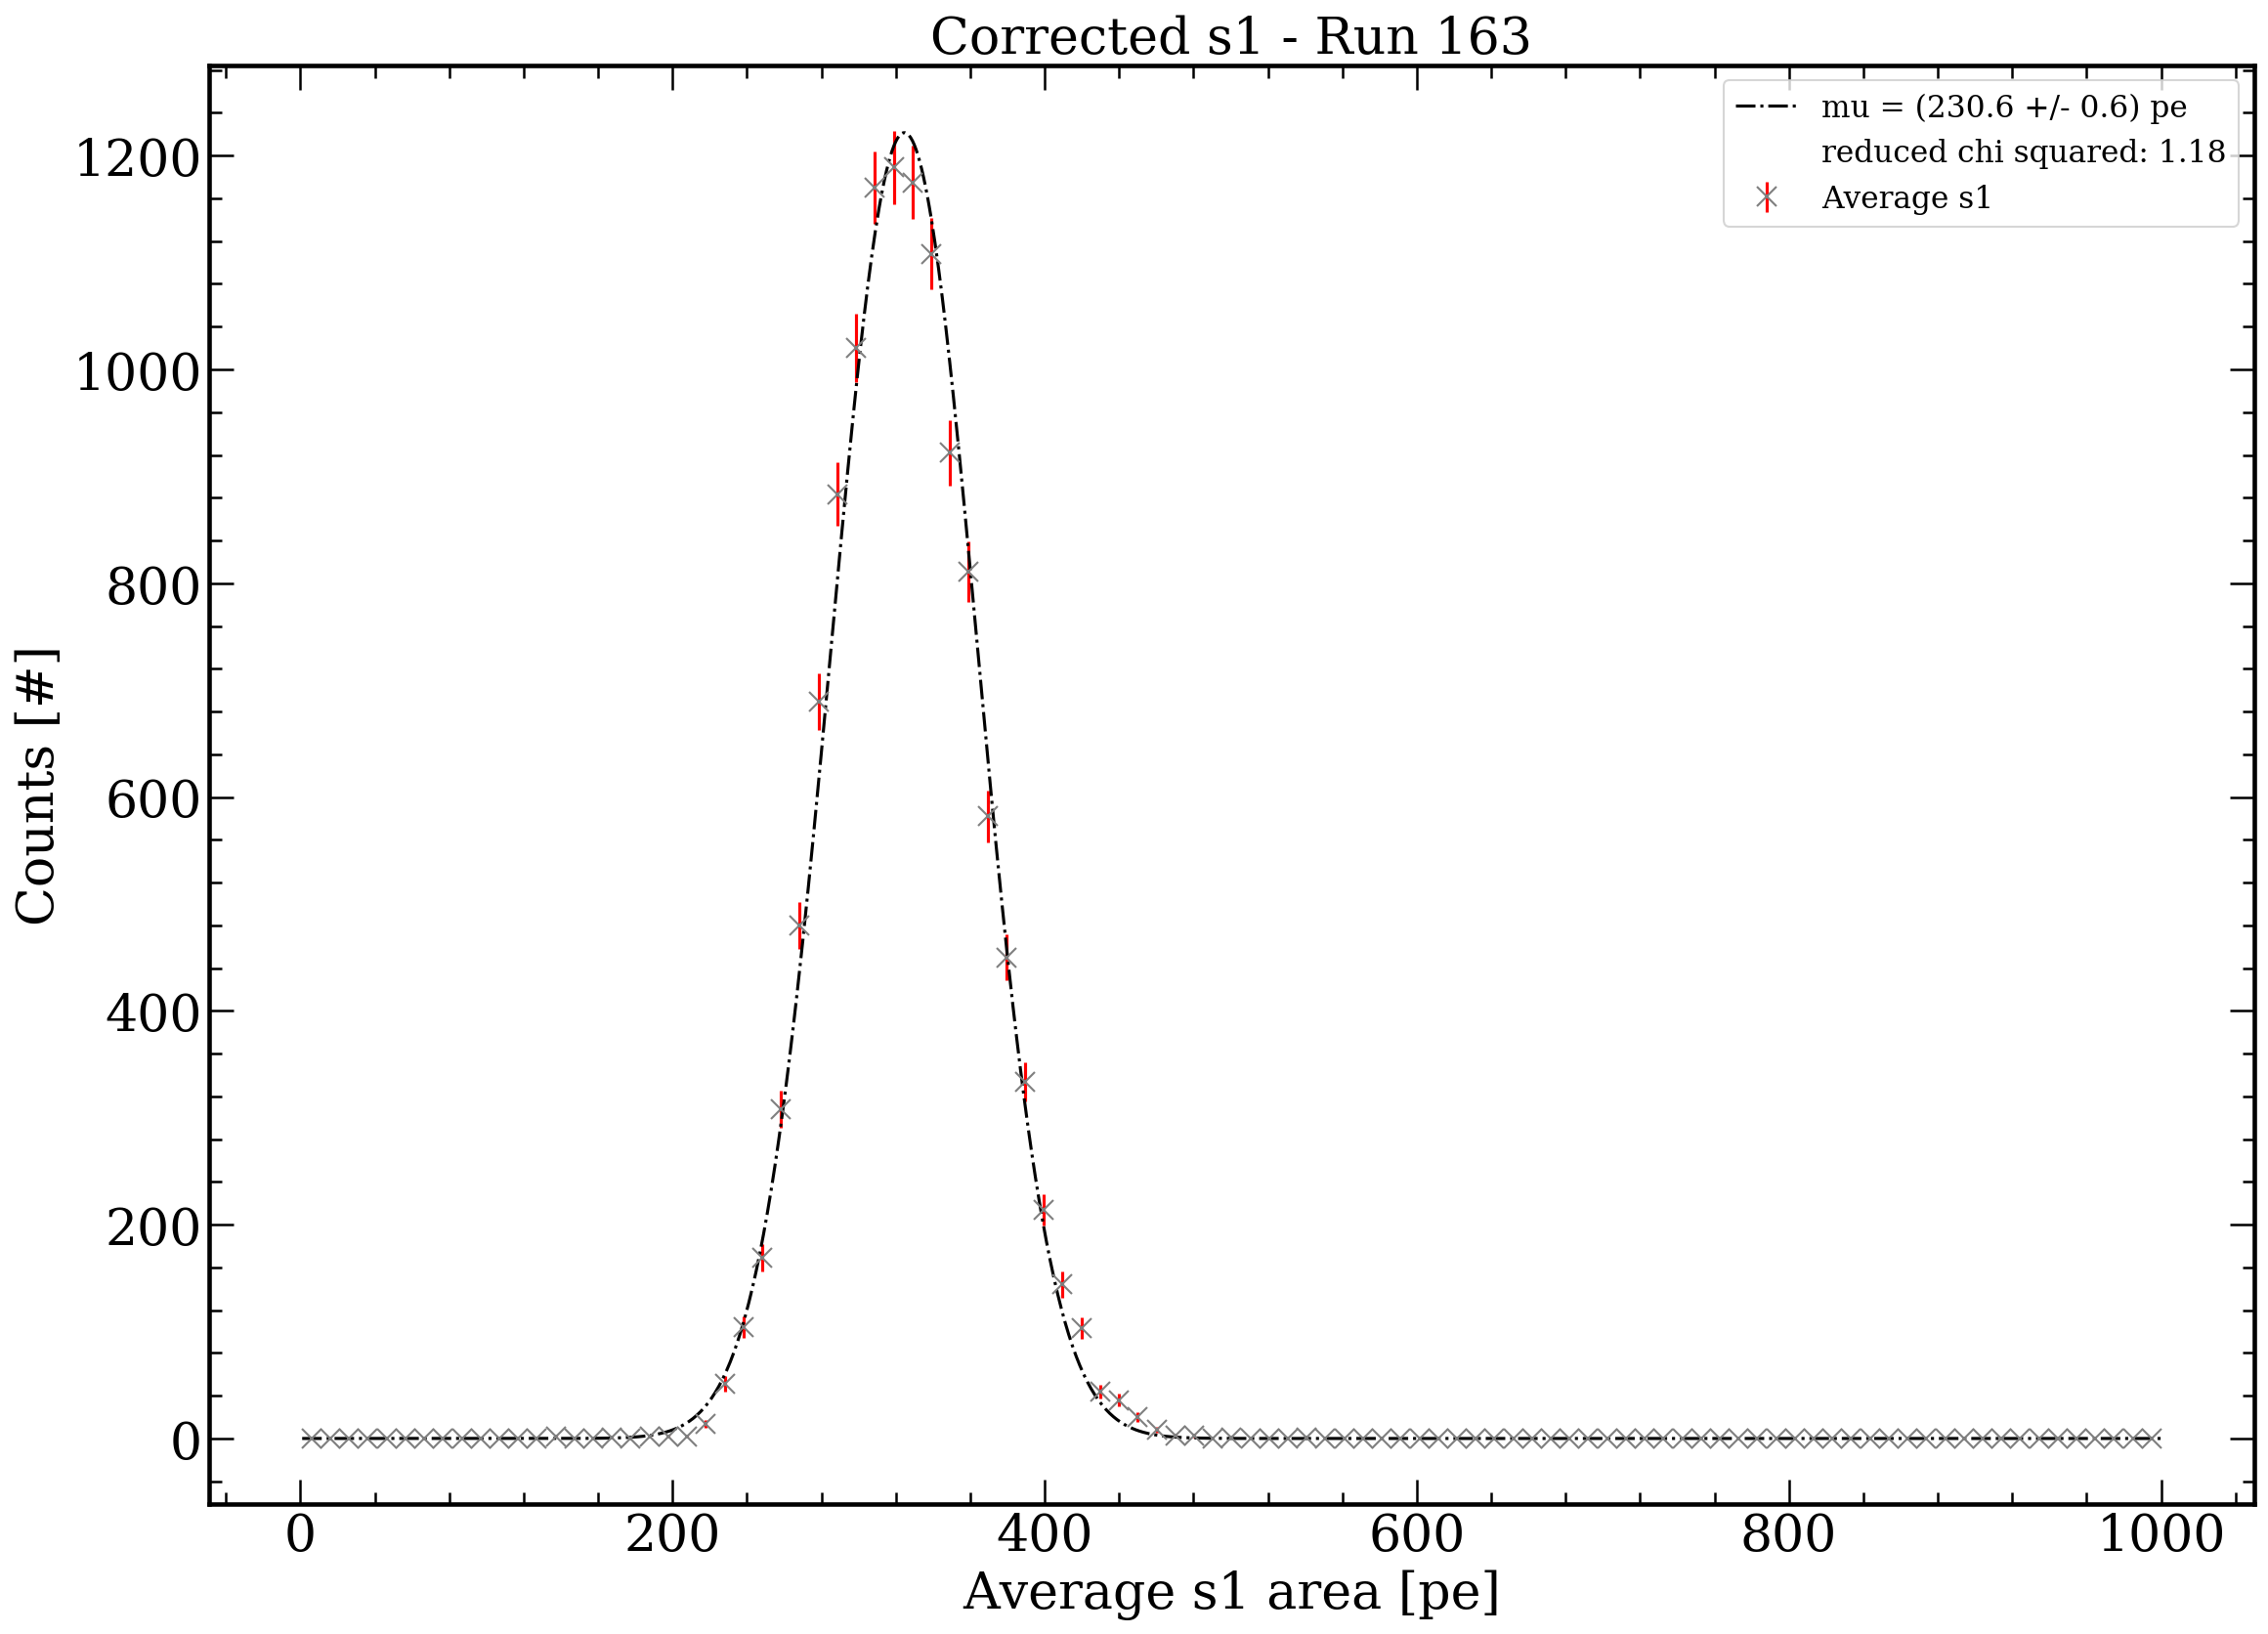

In [24]:
fig, axes = ps.styles()

p0_log = [1,1,1]
p0 = [500,300,60]


n, binEdges = np.histogram(s1_corrected, bins=np.linspace(1,1000,100))  #anode at 2500V

poisson_list = []

for i in n:
    a= poisson_interval(i)[1]
    poisson_list.append(a)


bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
x_range = np.linspace(1,1000,1000)

popt, pcov = curve_fit(gaus, bincenters, n, p0,  sigma = poisson_list, absolute_sigma = True, maxfev = 10000)
perr = np.sqrt(np.diag(pcov))




expectation = np.exp(popt[1]+((popt[2]**2)/2))
diff_mu = expectation
diff_sigma = expectation*popt[2]
error_mu = perr[1]
error_sigma = perr[2]   
error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

# s1_mu = f"{expectation:.1f}"

# s1_error = f"{error:.1f}"

s2_mu = f"{popt[1]:.1f}"

s2_error = f"{perr[1]:.1f}"


xdata=bincenters[1:-1]
ydata=n[1:-1]
chi_squared =  (np.sum((n - gaus(bincenters, *popt))**2 / np.array(poisson_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(xdata))
# print(Reduced_chi_squared)
s1_ly_corrected = f"{(np.array(popt[1])/41.5):.2f}"
s1_ly_error_corrected = f"{(np.array(perr[1])/41.5):.2f}"
print('average ly of run',run[2:],': (',s1_ly_corrected,'+/-',s1_ly_error_corrected,')','keV/pe')


axes.errorbar(bincenters, n, yerr=np.sqrt(n),marker = 'x', fmt='.',c = 'C7',markersize='10', ecolor='red', label='Average s1')
axes.plot(x_range,gaus(x_range,*popt), color = 'k', linestyle = '-.', label = 'mu = ('+s1_mu+ ' +/- '+s1_error+') pe')
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)
axes.set_title('Corrected s1 - Run '+run[2:])
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average s1 area [pe]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()




# 5.5 Playground

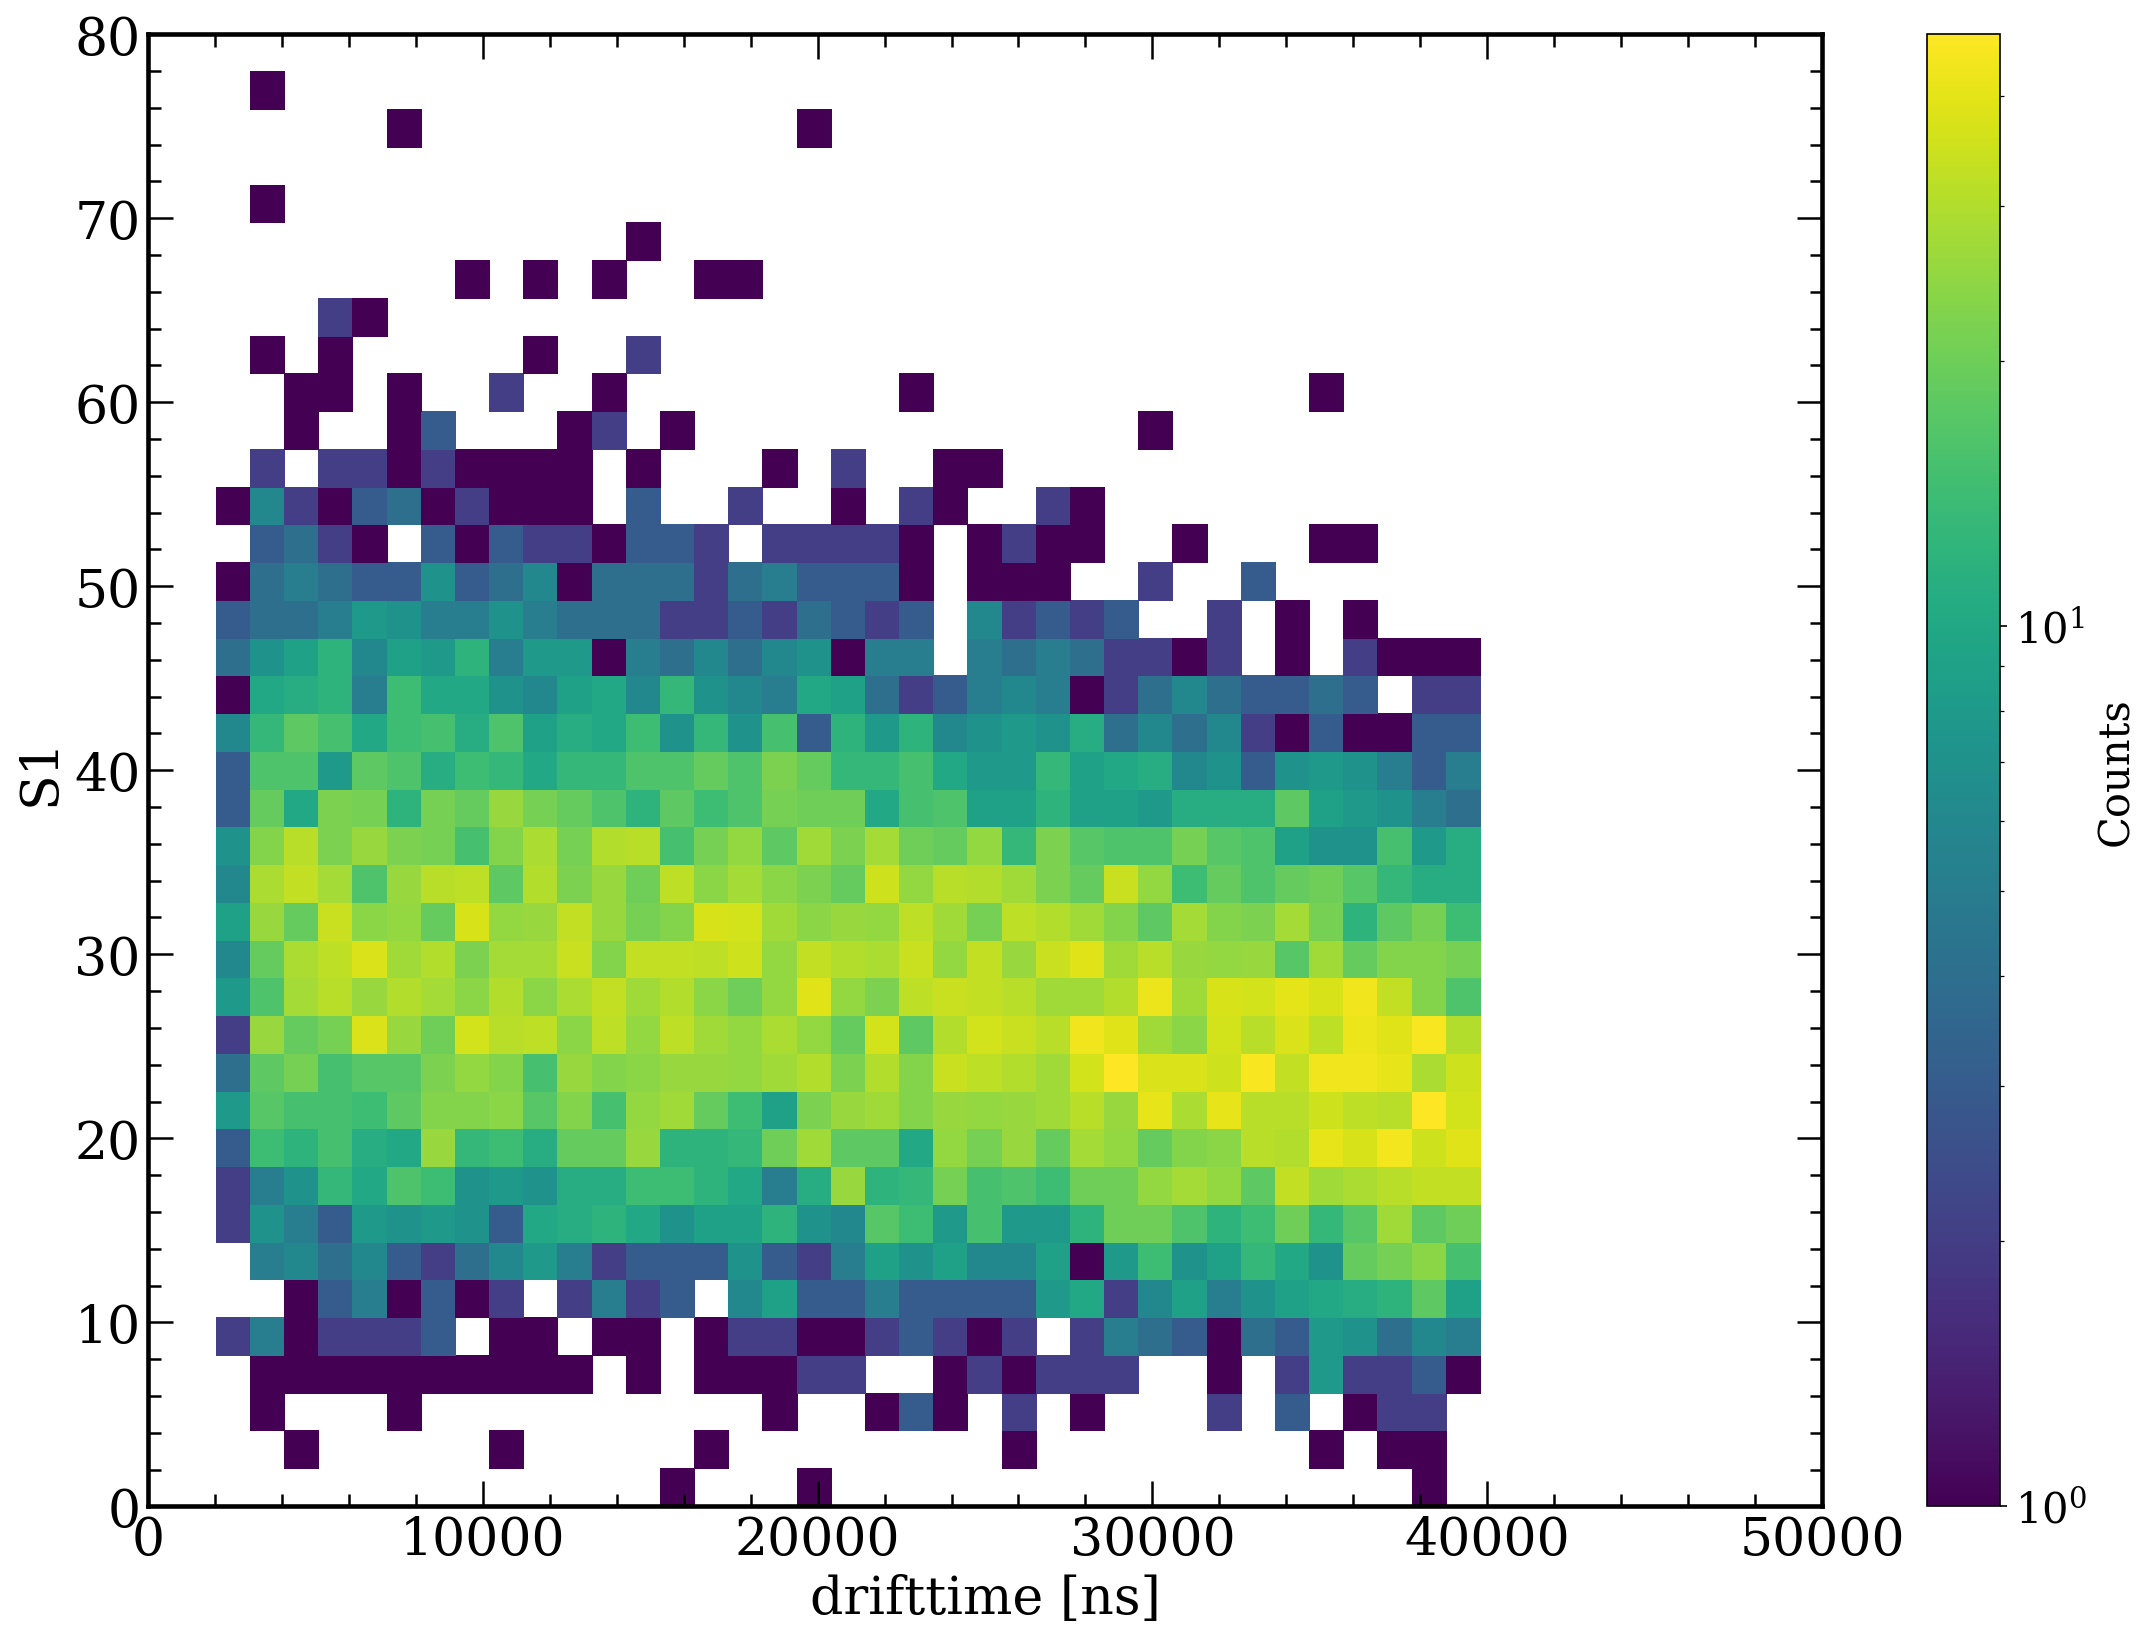

In [16]:
fig, axes = ps.styles()

bins_x = np.linspace(0,50000,50)
#bins_y = np.logspace(2,3,50)
bins_y = np.linspace(0,80,40)

def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval

counts, xedges, yedges = np.histogram2d(drifttime, s1_top, bins=(bins_x, bins_y))
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)
poisson_list_left = []
poisson_list_right = []

for i in counts:
    error_per_slice_left = []
    error_per_slice_right = []
    for j in i:
        b =poisson_interval(j)[1]
        a =poisson_interval(j)[0]
        error_per_slice_left.append(a)
        error_per_slice_right.append(b)
    poisson_list_left.append(error_per_slice_left)
    poisson_list_right.append(error_per_slice_right)


im = axes.pcolormesh(bins_x, bins_y, counts.T, cmap='viridis', norm=mcolors.LogNorm())
#axes.set_yscale('log')
axes.set_xlabel('drifttime [ns]')
axes.set_ylabel('S1')
cbar = plt.colorbar(im, ax=axes)
cbar.set_label('Counts',size=20)
cbar.ax.tick_params(labelsize=20) 
plt.show()

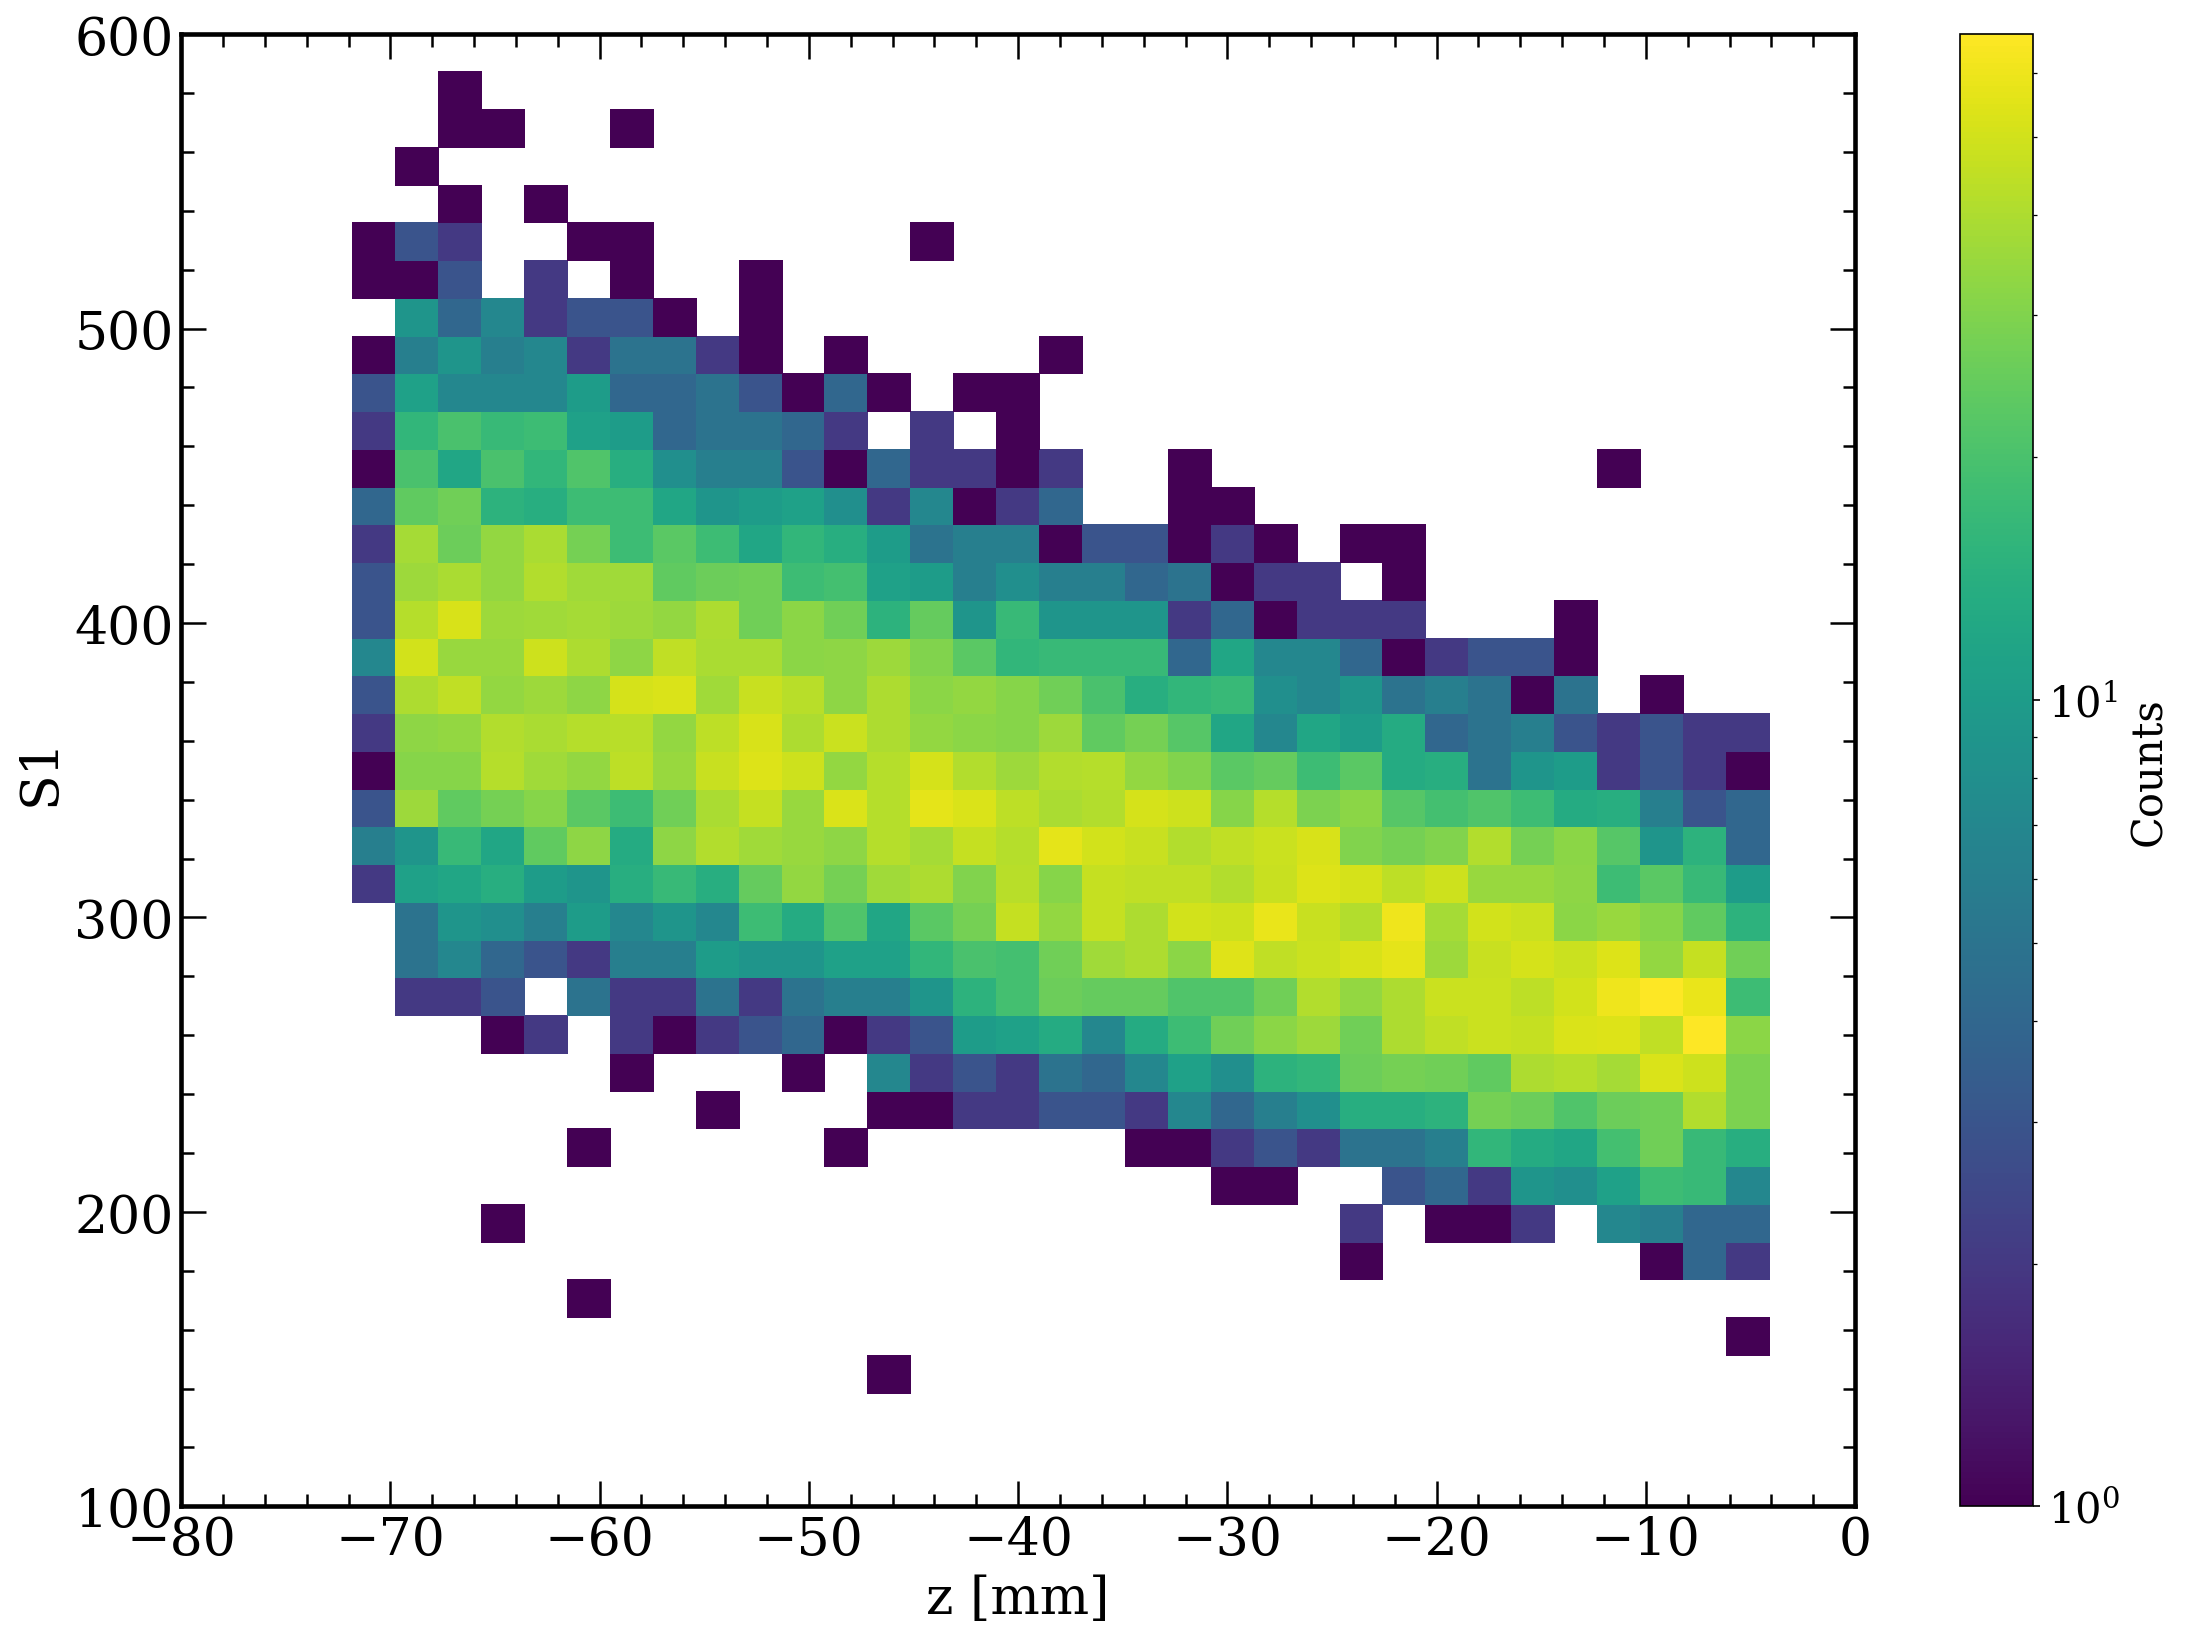

In [17]:
fig, axes = ps.styles()
z_absolute = []
for i in range(len(z)):
    z_absolute.append(abs(z[i]))
bins_x = np.linspace(-80,0,40)
#bins_y = np.logspace(2,3,50)
bins_y = np.linspace(100,600,40)

def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval

counts, xedges, yedges = np.histogram2d(z, s1, bins=(bins_x, bins_y))
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)
poisson_list_left = []
poisson_list_right = []

for i in counts:
    error_per_slice_left = []
    error_per_slice_right = []
    for j in i:
        b =poisson_interval(j)[1]
        a =poisson_interval(j)[0]
        error_per_slice_left.append(a)
        error_per_slice_right.append(b)
    poisson_list_left.append(error_per_slice_left)
    poisson_list_right.append(error_per_slice_right)


im = axes.pcolormesh(bins_x, bins_y, counts.T, cmap='viridis', norm=mcolors.LogNorm())
#axes.set_yscale('log')
axes.set_xlabel('z [mm]')
axes.set_ylabel('S1')
cbar = plt.colorbar(im, ax=axes)
cbar.set_label('Counts',size=20)
cbar.ax.tick_params(labelsize=20) 
plt.show()

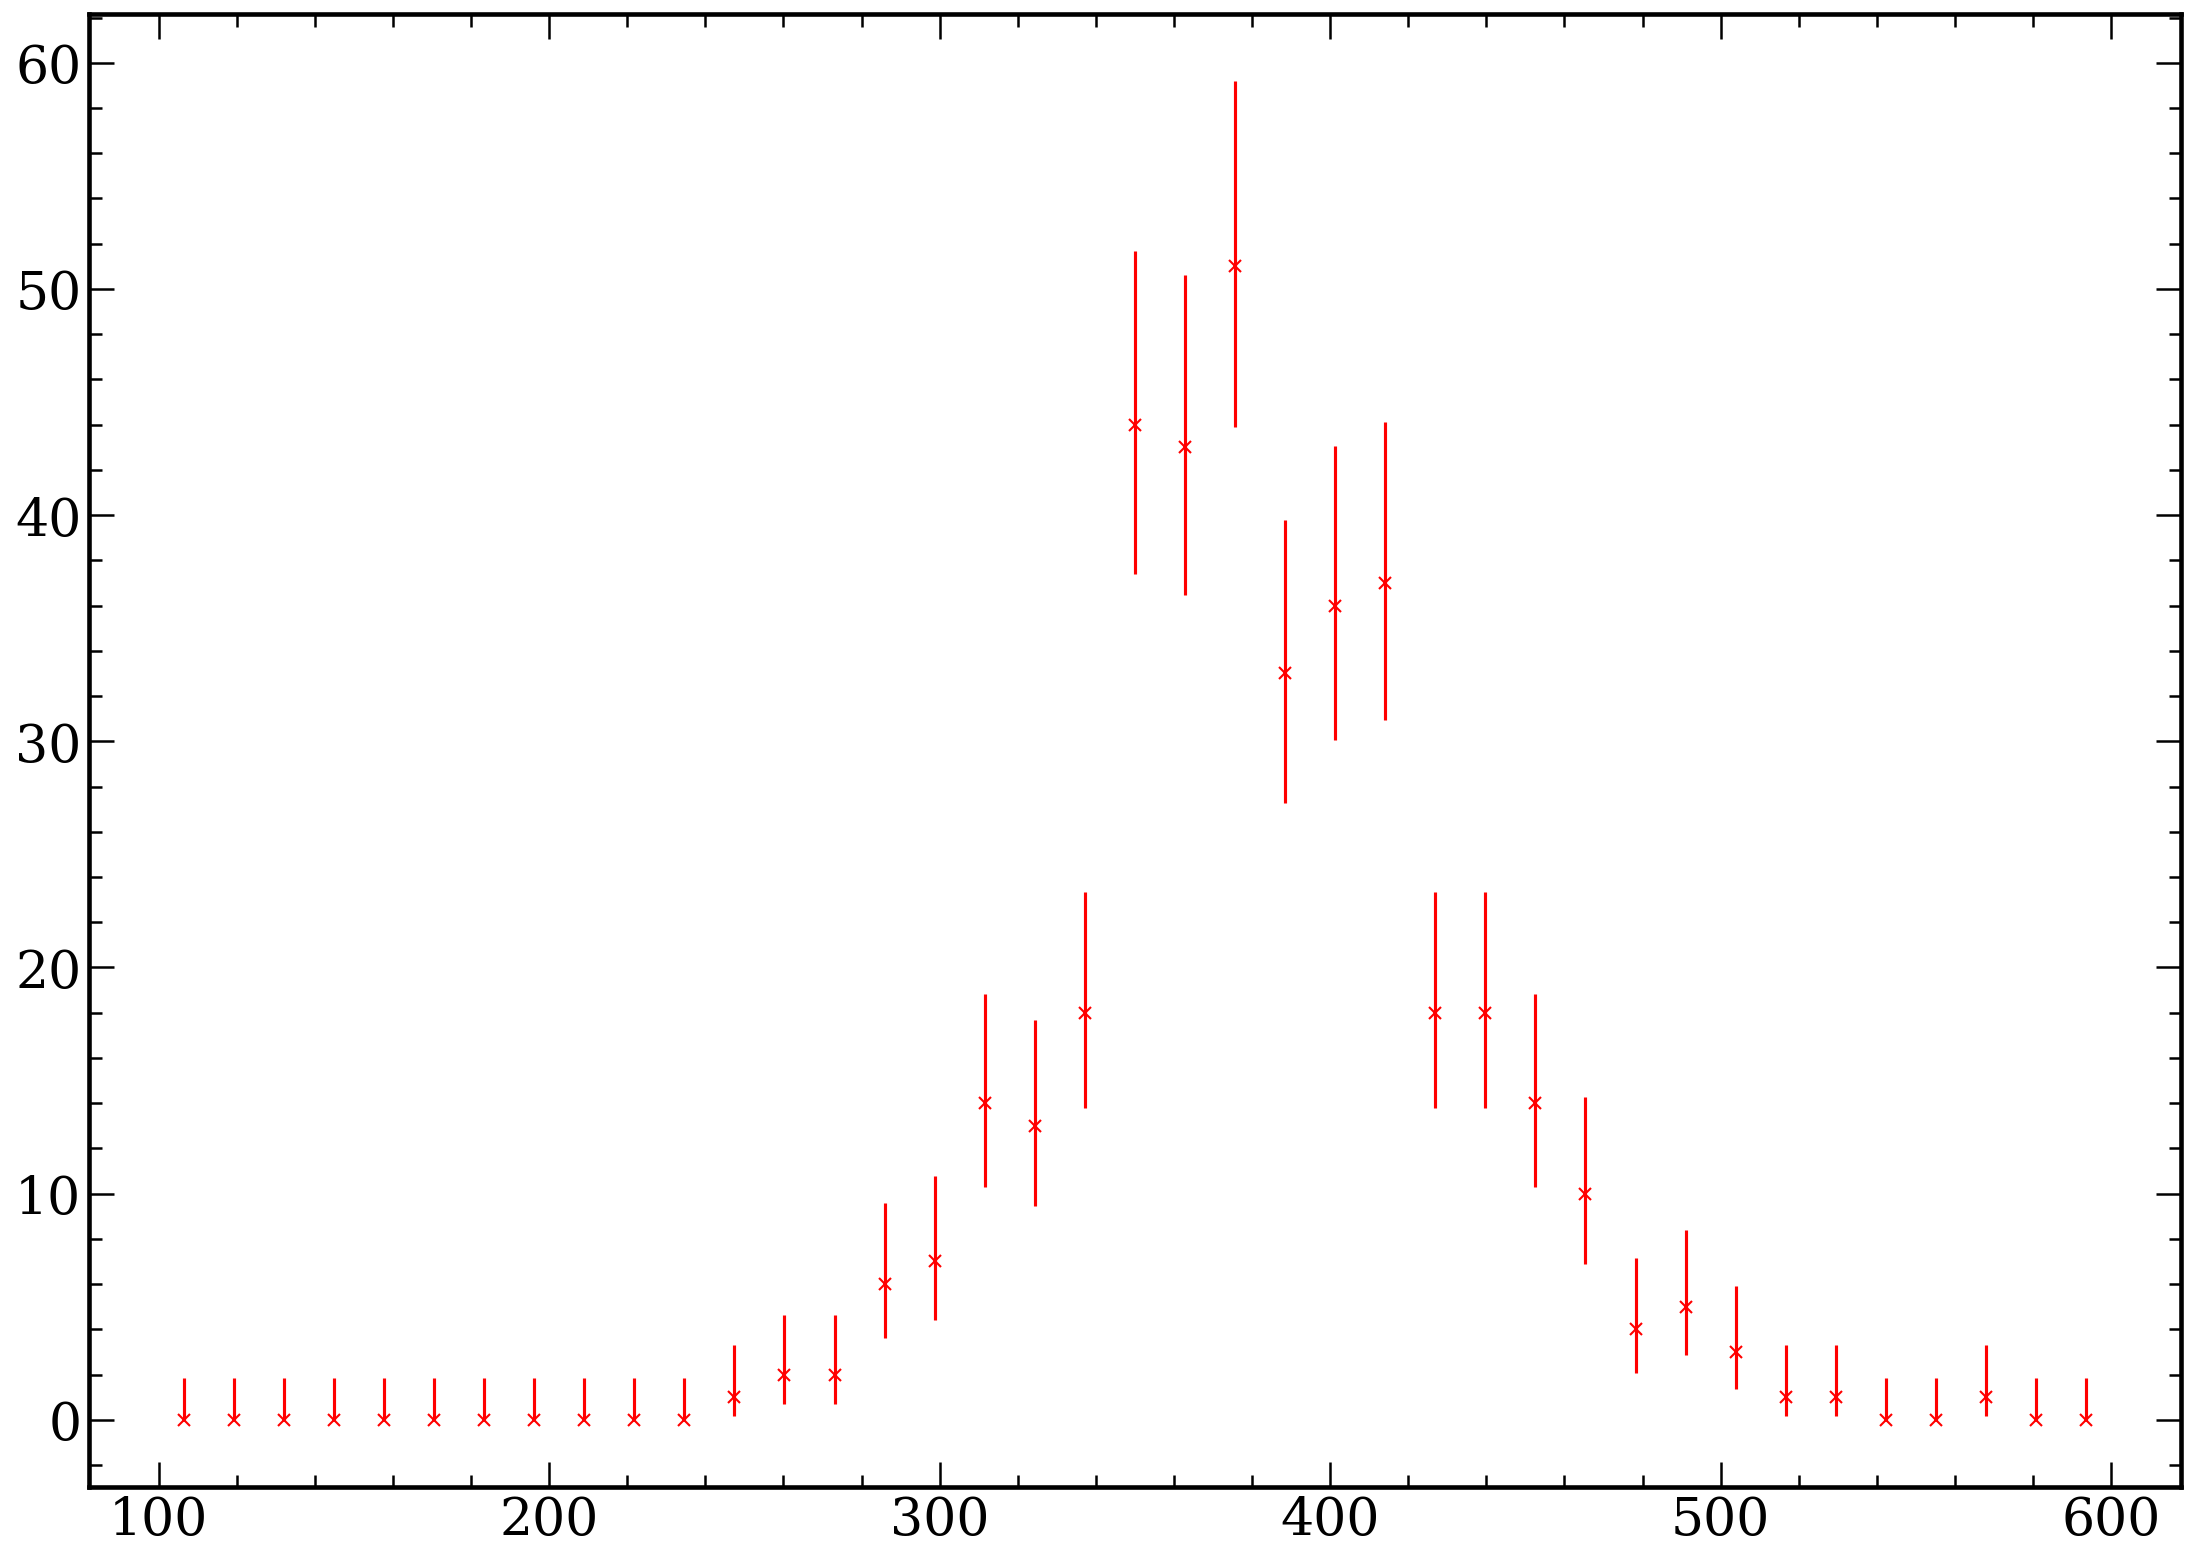

In [18]:
fig, axes = ps.styles()
fit_range= np.linspace(100,600,1000)

def log_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus

def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus



p0 = [1,250,30]
slice_id = 10

# popt, pcov = curve_fit(gaus, ycenter, counts[slice_id],sigma = poisson_list_right[slice_id], absolute_sigma = True, p0=p0, maxfev = 10000)
# print(popt)
# # print(ycenter)
# perr = np.sqrt(np.diag(pcov))
# print(perr[1])
axes.errorbar(ycenter, counts[slice_id], yerr=(poisson_list_left[slice_id],poisson_list_right[slice_id]), xerr=0, fmt = 'rx', label = 'average S2 size' )
# plt.plot(fit_range, gaus(fit_range, *popt))

plt.show()

# 6. 3D visualisation

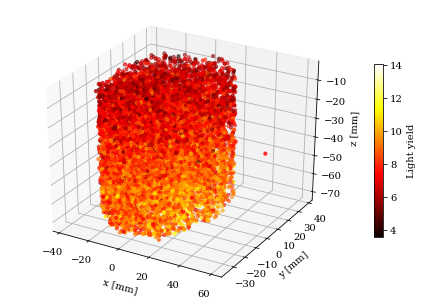

In [19]:


fig = plt.figure()
ax = Axes3D(fig)

#c=ly for uncorrected
#c=ly_corrected for corrected


# ax.scatter(x, y, z, c='b', marker='o',s=5)
im = ax.scatter(x, y, z, s=10, c=ly, cmap='hot')
# fig.colorbar(img,shrink=0.6)

cb = plt.colorbar(im, ax=ax, label='Ly',shrink=0.6)
cb.set_label('Light yield',size=10)
cb.ax.tick_params(labelsize=10)

ax.set_xlabel('x [mm]',fontsize=10)
ax.set_ylabel('y [mm]',fontsize=10)
ax.set_zlabel('z [mm]',fontsize=10)
plt.show()

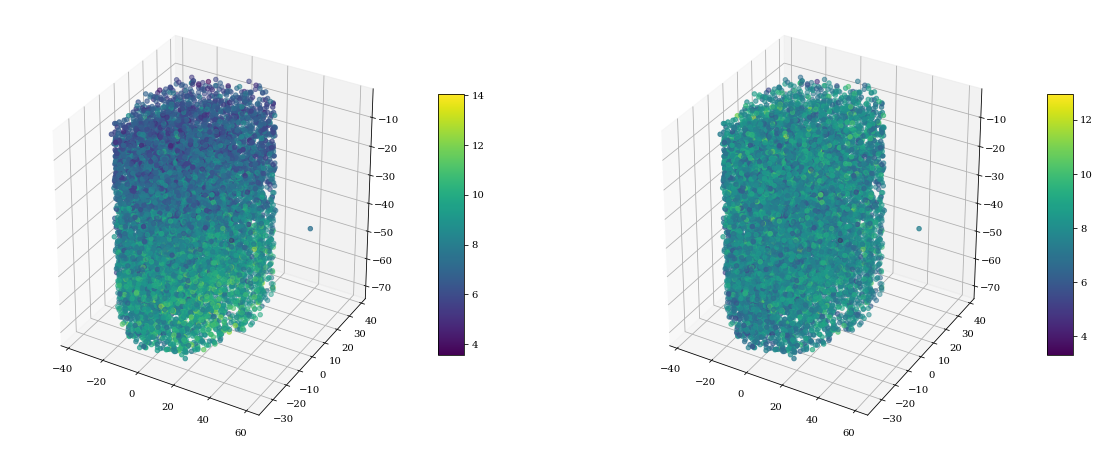

In [20]:


fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
im1 = ax1.scatter(x,y,z,c=ly, cmap='viridis')
fig.colorbar(im1, shrink=0.6, aspect=10)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
im2 = ax2.scatter(x,y,z,c=ly_corrected, cmap='viridis')
fig.colorbar(im2, shrink=0.6, aspect=10)

plt.show()

# 7. Light yield for 9.4keV and 32.1keV

In [21]:
left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 23

s1_9keV = []
s1_32keV = []
s1_9keV_corrected = []
s1_32keV_corrected = []
shape_float = float(shape)
offset_float = float(offset)
                                                
num = len(waveform)
print_counter = 0.0
for i in range(0,num-1):    
    Process_9keV_32keV(waveform,i)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')
    

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00163 done!


average ly of run 163 : ( 7.06 +/- 0.02 ) keV/pe


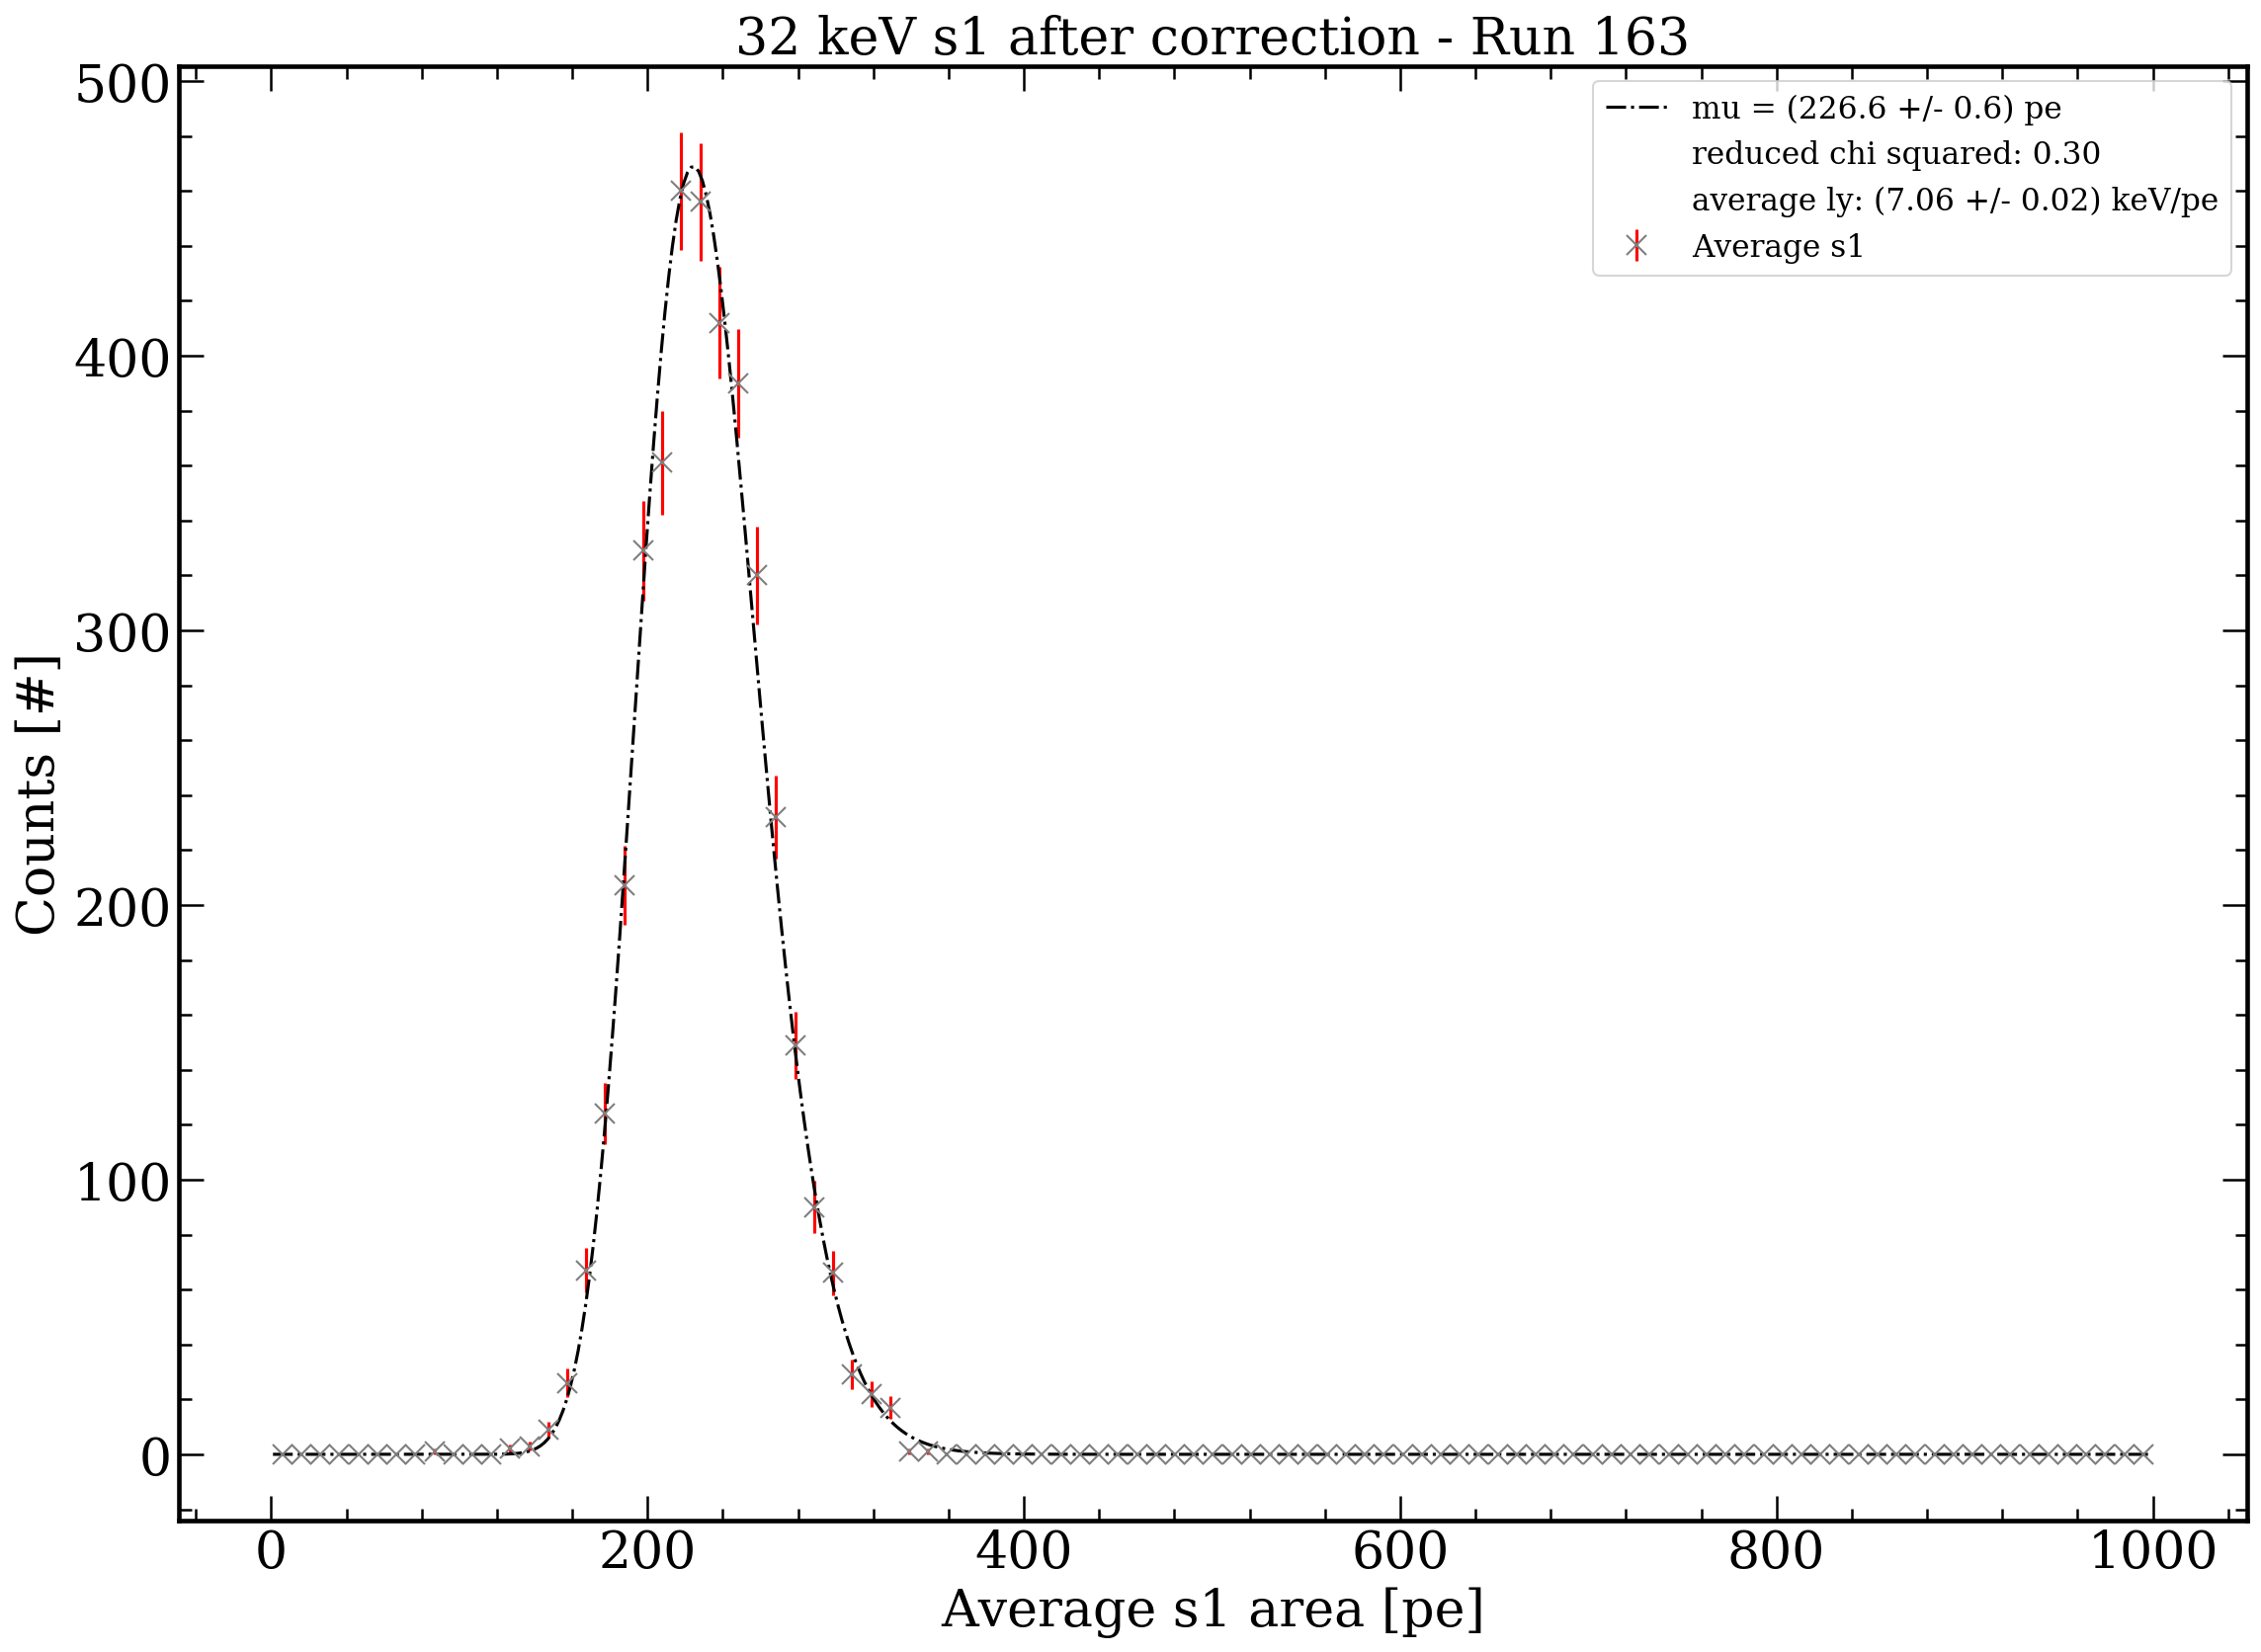

In [29]:
fig, axes = ps.styles()

p0_log = [1,1,1]
p0 = [500,200,60]


n, binEdges = np.histogram(s1_32keV_corrected, bins=np.linspace(1,1000,100))  #anode at 2500V

poisson_list = []

for i in n:
    a= poisson_interval(i)[1]
    poisson_list.append(a)


bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
x_range = np.linspace(1,1000,500)

popt, pcov = curve_fit(log_gaus, bincenters, n, p0_log,  sigma = poisson_list, absolute_sigma = True, maxfev = 10000)
perr = np.sqrt(np.diag(pcov))




expectation = np.exp(popt[1]+((popt[2]**2)/2))
diff_mu = expectation
diff_sigma = expectation*popt[2]
error_mu = perr[1]
error_sigma = perr[2]   
error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

s1_mu = f"{expectation:.1f}"

s1_error = f"{error:.1f}"

# s1_mu = f"{popt[1]:.1f}"

# s1_error = f"{perr[1]:.1f}"



xdata=bincenters[1:-1]
ydata=n[1:-1]
chi_squared =  (np.sum((n - log_gaus(bincenters, *popt))**2 / np.array(poisson_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(xdata))
# print(Reduced_chi_squared)
# s1_ly_corrected = f"{(np.array(expectation)/9.4):.2f}"
# s1_ly_error_corrected = f"{(np.array(error)/9.4):.2f}"
s1_ly_corrected = f"{(np.array(expectation)/32.1):.2f}"
s1_ly_error_corrected = f"{(np.array(error)/32.1):.2f}"

print('average ly of run',run[2:],': (',s1_ly_corrected,'+/-',s1_ly_error_corrected,')','keV/pe')


axes.errorbar(bincenters, n, yerr=np.sqrt(n),marker = 'x', fmt='.',c = 'C7',markersize='10', ecolor='red', label='Average s1')
axes.plot(x_range,log_gaus(x_range,*popt), color = 'k', linestyle = '-.', label = 'mu = ('+s1_mu+ ' +/- '+s1_error+') pe')
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)
axes.set_title('32 keV s1 after correction - Run '+run[2:])
axes.plot([], [], ' ', label="average ly: ("+s1_ly_corrected+' +/- '+s1_ly_error_corrected+') keV/pe')
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average s1 area [pe]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()


